<a href="https://colab.research.google.com/github/bosla67/Colab/blob/main/BuildingAssetTradingStrategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Building an Asset Trading Strategy**
https://www.kaggle.com/code/shtrausslearning/building-an-asset-trading-strategy/notebook

In [1]:
!pip install catboost
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.5 MB/s eta 0:00:00


In [2]:
# download data file
# ! wget https://transfer.sh/uWWDfzcAIY/data22.csv
# ! wget https://transfer.sh/U7TjAuGP2W/data22_2_1.csv

# !wget https://oshi.at/mNZE
# ! pwd
# ! ls -la

In [3]:
# сбалансированная 3 класса
!wget https://github.com/bosla67/Colab/raw/refs/heads/main/Data/EURUSD/2015/EURUSD_1_bal.zip -O EURUSD_1_bal.zip
!unzip ./EURUSD_1_bal.zip -d ./Data
!rm ./EURUSD_1_bal.zip


--2025-02-28 11:18:43--  https://github.com/bosla67/Colab/raw/refs/heads/main/Data/EURUSD/2015/EURUSD_1_bal.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/bosla67/Colab/refs/heads/main/Data/EURUSD/2015/EURUSD_1_bal.zip [following]
--2025-02-28 11:18:44--  https://raw.githubusercontent.com/bosla67/Colab/refs/heads/main/Data/EURUSD/2015/EURUSD_1_bal.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25156868 (24M) [application/zip]
Saving to: ‘EURUSD_1_bal.zip’

EURUSD_1_bal.zip    100%[===================>]  23.99M   157MB/s    in 0.2s    

2025-02-28 11:18:45 (157 MB/s) - ‘EURUSD_1_bal.zip

In [4]:
header_file_location = './Data/EURUSD_1_head.csv'
signal_file_location = './Data/EURUSD_1_signal.bin'
label_file_location = './Data/EURUSD_1_label.bin'

In [5]:
# Header processing
with open(header_file_location, 'r') as file:
    content = file.readlines()

meta = dict()
meta['columns'] = content[0].strip().split('\t')
meta.update(dict( [(param, int(val)) for param, val in [l.strip().split('\t') for l in content[1:]]]))
print('Columns\t',meta['cntColumns'])
print('Sequence\t', meta['lenSequence'])
print('Records\t', meta['cntRecords'])


Columns	 90
Sequence	 20
Records	 140658


In [6]:
# meta['columns']

In [7]:
import pandas as pd
import numpy as np
import struct

In [8]:
#############################################################
# define a np.dtype that matches our binary record layout
# labels file
dt_label=np.dtype([
    ('date_time', '<f8'),
    ('signal', '<i1'),
    ('label', '<i1')
])

with open(label_file_location, 'rb') as f:
    bin = f.read()

np_data_l = np.frombuffer(bin, dtype=dt_label)
f_labels = pd.DataFrame(np_data_l)
f_labels.index = pd.to_datetime(f_labels.date_time, unit='s')
f_labels.drop('date_time', axis=1, inplace=True)
print(f_labels.label.value_counts())
#
f_labels

label
 1    48826
-1    46271
 0    45561
Name: count, dtype: int64


signal  label
date_time                                   
2015-01-07 12:00:26.802000046      12      1
2015-01-07 12:00:28.628999949      21      1
2015-01-07 12:00:51.471999884      31     -1
2015-01-07 12:01:00.665999889      12      1
2015-01-07 12:01:01.665999889      13      1
...                               ...    ...
2015-07-03 23:45:18.555999994      31      1
2015-07-03 23:46:51.520999907      42      1
2015-07-03 23:46:56.085999966      31      1
2015-07-03 23:46:56.739000082      11      1
2015-07-03 23:48:12.000000000      42      1

[140658 rows x 2 columns]

In [9]:
# define a np.dtype that matches our binary record layout
# signal file
dt_signal = np.dtype(f"f8, i1, ({meta['cntColumns']}, {meta['lenSequence']} )i2")

with open(signal_file_location, 'rb') as f:
    bin = f.read()

np_data_s = np.frombuffer(bin, dtype=dt_signal)

# Load first two columns ('f0' and 'f1') into a pandas DataFrame
f_signals = pd.DataFrame(np_data_s[['f0', 'f1']])
f_signals.index = pd.to_datetime(f_signals.f0, unit='s')
f_signals.drop('f0', axis=1, inplace=True)

# Remove first two columns from the ndarray
np_data_s = np_data_s['f2']  # Keep only the 'f2' column in the ndarray

In [10]:
(len(f_signals), len(f_labels))

(140661, 140658)

Поскольку в конце периода имеются "неотработавшие/неопределенные" метки необходимо синхронизировать датафреймы

In [11]:
# для вибору поточного значення  -1
# для вибору останнього сформованого значення  -2
takeBar = -1

# добавим данні з numpy ndarray в df
for colName in meta['columns']:
    f_signals[colName] = np_data_s[:, meta['columns'].index(colName), takeBar]

print(len(f_signals))
f_signals.head()

140661


f1  ama_m_diff_H4_D1  ama_m_diff_H1_H4  \
f0                                                                      
2015-01-07 12:00:26.802000046  12             -2761                 8   
2015-01-07 12:00:28.628999949  21             -2759                 6   
2015-01-07 12:00:51.471999884  31             -2749                 1   
2015-01-07 12:01:00.665999889  12             -2749                 1   
2015-01-07 12:01:01.665999889  13             -2749                 1   

                               ama_m_diff_M15_H1  ama_m_diff_M5_M15  \
f0                                                                    
2015-01-07 12:00:26.802000046               -243                -65   
2015-01-07 12:00:28.628999949               -244                -63   
2015-01-07 12:00:51.471999884               -245                -59   
2015-01-07 12:01:00.665999889               -245                -59   
2015-01-07 12:01:01.665999889               -245                -59   

                               ama_m_diff_M1_M5  ch_ama_m_H4  ch_ama_m_H1  \
f0                                                                          
2015-01-07 12:00:26.802000046               -68          -89          -19   
2015-01-07 12:00:28.628999949               -68          -87          -18   
2015-01-07 12:00:51.471999884               -72          -78          -14   
2015-01-07 12:01:00.665999889               -72          -78          -14   
2015-01-07 12:01:01.665999889               -72          -78          -14   

                               ch_ama_m_M15  ch_ama_m_M5  ...  stc_d2_H4  \
f0                                                        ...              
2015-01-07 12:00:26.802000046            -7          -12  ...         13   
2015-01-07 12:00:28.628999949            -6          -10  ...         13   
2015-01-07 12:00:51.471999884            -3           -3  ...         14   
2015-01-07 12:01:00.665999889            -3           -3  ...         13   
2015-01-07 12:01:01.665999889            -3           -3  ...         13   

                               stc_k2_H4  stc_d2_H1  stc_k2_H1  stc_d2_M15  \
f0                                                                           
2015-01-07 12:00:26.802000046         11         20         16          19   
2015-01-07 12:00:28.628999949         12         20         17          20   
2015-01-07 12:00:51.471999884         12         21         18          21   
2015-01-07 12:01:00.665999889         11         20         16          19   
2015-01-07 12:01:01.665999889         11         20         16          19   

                               stc_k2_M15  stc_d2_M5  stc_k2_M5  stc_d2_M1  \
f0                                                                           
2015-01-07 12:00:26.802000046          12         13         15         20   
2015-01-07 12:00:28.628999949          14         14         18         23   
2015-01-07 12:00:51.471999884          16         16         22         24   
2015-01-07 12:01:00.665999889          12         13         16         26   
2015-01-07 12:01:01.665999889          13         13         16         26   

                               stc_k2_M1  
f0                                        
2015-01-07 12:00:26.802000046         26  
2015-01-07 12:00:28.628999949         31  
2015-01-07 12:00:51.471999884         35  
2015-01-07 12:01:00.665999889         33  
2015-01-07 12:01:01.665999889         33  

[5 rows x 91 columns]

In [12]:
# Обєднання датафреймів по індексу
result1 = pd.merge(f_signals, f_labels, left_index=True, right_index=True, how='inner')
result1.drop(result1.columns[0], axis=1, inplace=True) # видалення колонки 'f1' з номером сигналу (дублюється f_signals[f1]=f_labels[signal])
print(len(result1))
result1.head()

140658


ama_m_diff_H4_D1  ama_m_diff_H1_H4  \
2015-01-07 12:00:26.802000046             -2761                 8   
2015-01-07 12:00:28.628999949             -2759                 6   
2015-01-07 12:00:51.471999884             -2749                 1   
2015-01-07 12:01:00.665999889             -2749                 1   
2015-01-07 12:01:01.665999889             -2749                 1   

                               ama_m_diff_M15_H1  ama_m_diff_M5_M15  \
2015-01-07 12:00:26.802000046               -243                -65   
2015-01-07 12:00:28.628999949               -244                -63   
2015-01-07 12:00:51.471999884               -245                -59   
2015-01-07 12:01:00.665999889               -245                -59   
2015-01-07 12:01:01.665999889               -245                -59   

                               ama_m_diff_M1_M5  ch_ama_m_H4  ch_ama_m_H1  \
2015-01-07 12:00:26.802000046               -68          -89          -19   
2015-01-07 12:00:28.628999949               -68          -87          -18   
2015-01-07 12:00:51.471999884               -72          -78          -14   
2015-01-07 12:01:00.665999889               -72          -78          -14   
2015-01-07 12:01:01.665999889               -72          -78          -14   

                               ch_ama_m_M15  ch_ama_m_M5  ch_ama_m_M1  ...  \
2015-01-07 12:00:26.802000046            -7          -12           -4  ...   
2015-01-07 12:00:28.628999949            -6          -10           -2  ...   
2015-01-07 12:00:51.471999884            -3           -3            0  ...   
2015-01-07 12:01:00.665999889            -3           -3            0  ...   
2015-01-07 12:01:01.665999889            -3           -3            0  ...   

                               stc_d2_H1  stc_k2_H1  stc_d2_M15  stc_k2_M15  \
2015-01-07 12:00:26.802000046         20         16          19          12   
2015-01-07 12:00:28.628999949         20         17          20          14   
2015-01-07 12:00:51.471999884         21         18          21          16   
2015-01-07 12:01:00.665999889         20         16          19          12   
2015-01-07 12:01:01.665999889         20         16          19          13   

                               stc_d2_M5  stc_k2_M5  stc_d2_M1  stc_k2_M1  \
2015-01-07 12:00:26.802000046         13         15         20         26   
2015-01-07 12:00:28.628999949         14         18         23         31   
2015-01-07 12:00:51.471999884         16         22         24         35   
2015-01-07 12:01:00.665999889         13         16         26         33   
2015-01-07 12:01:01.665999889         13         16         26         33   

                               signal  label  
2015-01-07 12:00:26.802000046      12      1  
2015-01-07 12:00:28.628999949      21      1  
2015-01-07 12:00:51.471999884      31     -1  
2015-01-07 12:01:00.665999889      12      1  
2015-01-07 12:01:01.665999889      13      1  

[5 rows x 92 columns]

In [13]:
# # Шукаєм та видаляєм розбіжності
# f_signals.index.difference(f_labels.index)

In [14]:
# f_signals[-5:]

In [15]:
# # Remove last 3 elements (as not labeled)
# f_signals=f_signals[:-3]
# print("f_signals len = ", len(f_signals))

# np_data_s=np_data_s[:-3]
# print("np_data_s len = ", len(np_data_s))
# np_data_s.shape


Після виконаної перевірки ми маєм датафрейми однакового розміру і з однаковими індексами а також відповідний їм numpy ndarray (140658, 90, 20)



In [16]:
# f_labels.info()

In [17]:
# len(f_labels)

In [18]:
# підготуєм df для тренування 100 000
df1 = result1.iloc[:100000]
print(df1.label.value_counts())        # absolute
df1.label.value_counts()/len(df1)       # %


label
 1    34718
-1    33934
 0    31348
Name: count, dtype: int64


label
 1    0.34718
-1    0.33934
 0    0.31348
Name: count, dtype: float64

In [19]:
# Переносим все label=0 в df1_0
df1_0 = pd.DataFrame(columns=df1.columns)  # df for save '0' labels

# Define the condition to move records
condition = df1['label'] == 0  # Example condition: Select rows where 'label'==0

# Move records from df to df0 based on the condition
df1_0 = pd.concat([df1_0, df1[condition]])

# Remove the moved records from df
df1 = df1[~condition]

# Output the result
print('df1_0--------------\n',df1_0.label.value_counts())
print('df1--------------\n',df1.label.value_counts())

df1_0--------------
 label
0    31348
Name: count, dtype: int64
df1--------------
 label
 1    34718
-1    33934
Name: count, dtype: int64


<ipython-input-19-97c1467cb98e>:8: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df1_0 = pd.concat([df1_0, df1[condition]])


In [20]:
# Replacing 'label' with 0 in the 'label' column
df1['label'].mask(df1['label'] == -1, 0, inplace=True)
print('df1_0--------------\n',df1_0.label.value_counts())
print('df1--------------\n',df1.label.value_counts())

df1_0--------------
 label
0    31348
Name: count, dtype: int64
df1--------------
 label
1    34718
0    33934
Name: count, dtype: int64


<ipython-input-20-5f7118da5c56>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['label'].mask(df1['label'] == -1, 0, inplace=True)
<ipython-input-20-5f7118da5c56>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['label'].mask(df1['label'] == -1, 0, inplace=True)


In [21]:
# f_signals[['mom0_H4','mom0_H1','mom0_M15','mom0_M5','mom0_M1']].describe()
# f_signals[['mom0_H4','mom0_H1','mom0_M15','mom0_M5','mom0_M1', 'mom1_H4','mom1_H1','mom1_M15','mom1_M5','mom1_M1', 'mom2_H4','mom2_H1','mom2_M15','mom2_M5','mom2_M1']][:20]
# # f_signals.describe()


In [22]:
import os
import numpy as np
import pandas as pd
import seaborn as sns;sns.set()
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

import matplotlib.pyplot as plt
from matplotlib import cm
from pandas import read_csv, set_option
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer,RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier,CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.feature_selection import SelectKBest,f_regression
from xgboost import plot_importance,XGBClassifier,XGBRegressor
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import preprocessing
import shap

from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.decomposition import FastICA
from sklearn.manifold import Isomap
from sklearn.manifold import MDS
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import TSNE
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection

# for dirname, _, filenames in os.walk('/kaggle/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

import time
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
%matplotlib inline

# time series cross validation
# https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/

''' FUNCTIONS '''

# One plot type
def plot_line(ldf,lst,title='',sec_id=None,size=[350,1000]):

    # sec_id - list of [False,False,True] values of when to activate supblots; same length as lst

    if(sec_id is not None):
        fig = make_subplots(specs=[[{"secondary_y": True}]])
    else:
        fig = go.Figure()

    if(len(lst) is not 1):
        ii=-1
        for i in lst:
            ii+=1
            if(sec_id is not None):
                fig.add_trace(go.Scatter(x=ldf.index, y=ldf[lst[ii]],mode='lines',name=lst[ii],line=dict(width=2.0)),secondary_y=sec_id[ii])
            else:
                fig.add_trace(go.Scatter(x=ldf.index, y=ldf[lst[ii]],mode='lines',name=lst[ii],line=dict(width=2.0)))
    else:
        fig.add_trace(go.Scatter(x=ldf.index, y=ldf[lst[0]],mode='lines',name=lst[0],line=dict(width=2.0)))

    fig.update_layout(height=size[0],width=size[1],template='plotly_white',title=title,
                          margin=dict(l=50,r=80,t=50,b=40));fig.show()

# plot n verticle subplots
def plot_vsubplots(ldf,lst,title='',nplots=None,lw_id=None,size=[400,1000]):

    # lw_id list of line widths if added

    assert(nplots is not None)
    fig = make_subplots(rows=nplots,shared_xaxes=True)
    ii=-1
    for i in lst:
        ii+=1
        fig.add_trace(go.Scatter(x=ldf.index,y=ldf[lst[ii]], mode='lines',name=lst[ii],line=dict(width=lw_id[ii])), row=ii+1, col=1)

    fig.update_layout(height=size[0],width=size[1],template='plotly_white',title=title,
                          margin=dict(l=50,r=80,t=50,b=40));fig.show()

colours = ['tab:blue','tab:red','tab:green']
def plot_line2(ldf,lst,title=''):

    ii=-1
    plt.figure(figsize=(14,5))
    for i in lst:
        ii+=1
        ax = ldf[lst[ii]].plot(color=colours[ii],label=lst[ii],lw=1.5)
    plt.title(title)
    plt.legend();plt.show()

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot Correlation to Target Variable only
def corrMat(df,target='demand',figsize=(9,0.5),ret_id=False):

    corr_mat = df.corr().round(2);shape = corr_mat.shape[0]
    corr_mat = corr_mat.transpose()
    corr = corr_mat.loc[:, df.columns == target].transpose().copy()

    if(ret_id is False):
        f, ax = plt.subplots(figsize=figsize)
        sns.heatmap(corr,vmin=-0.3,vmax=0.3,center=0,
                     cmap=cmap,square=False,lw=2,annot=True,cbar=False)
        plt.title(f'Feature Correlation to {target}')

    if(ret_id):
        return corr

def bar_plot(x, y,palette_len,title='Missing Values (%)', xlim = None, ylim = None,
             xticklabels = None, yticklabels = None,xlabel = None, ylabel = None,
             figsize = (10,4),axis_grid = 'y'):

    cmap = sns.color_palette("plasma")
    fig, ax = plt.subplots(figsize = figsize)
    plt.title(title,size = 15, fontweight = 'bold')

    for i in ['top', 'right', 'bottom', 'left']:
        ax.spines[i].set_color('black')

    ax.spines['top'].set_visible(True);ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False);ax.spines['left'].set_visible(False)

    sns.barplot(x = x, y = y, edgecolor = 'black', ax = ax,
                palette = cmap)
    ax.set_xlim(xlim);ax.set_ylim(ylim)
    ax.set_xticklabels(xticklabels);ax.set_yticklabels(yticklabels)
    plt.xlabel(xlabel);plt.ylabel(ylabel)
    ax.grid(axis = axis_grid,ls='--',alpha = 0.9)
    plt.show()

# function to plot a two PCA Feature Plot using Pandas
def scatterPlot(xDF, yDF, algoName):

    sns.set_style('whitegrid')
    fig, ax = plt.subplots()
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["Component 1","Component 2","Label"]
    g = sns.scatterplot(x="Component 1",y="Component 2",data=tempDF,hue="Label",
                        linewidth=0.5,alpha=0.5,s=15,edgecolor='k')
    plt.title(algoName);plt.legend()

    for i in ['top', 'right', 'bottom', 'left']:
        ax.spines[i].set_color('black')

    ax.spines['top'].set_visible(False);ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False);ax.spines['left'].set_visible(False)
    ax.grid(axis = 'both',ls='--',alpha = 0.9)
    plt.show()


# reduce memory (@mfjwr1); distorts the data a little (but reduces by 60% memory)
def red_mem(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# Split for TimeSeries
def TimeSeries_Split(ldf,
                     split_id=[None,None],
                     test_id=False,
                     cut_id=None):

    # Reduce the number of used data
    if(cut_id is not None):
        print('Reducing Input Data')

        if(type(cut_id) is int):
            ldf = ldf.iloc[-cut_id:]
        else:
            # input anything other than int
            print('Slicing based on period')
            ldf = ldf[data_period]

        t1 = ldf.index.max();t0 = ldf.index.min()
        print(f'Dataset Min.Index: {t0} | Max.Index: {t1}')

    if(split_id[0] is not None):
        # General Percentage Split (Non Shuffle requied for Time Series)
        train_df,pred_df = train_test_split(ldf,test_size=split_id[0],shuffle=False)
    elif(split_id[1] is not None):
        # specific time split
        train_df = df.loc[:split_id[1]]; pred_df = df.loc[split_id[1]:]
    else:
        print('Choose One Splitting Method Only')

#     y_train = train_df[feature]
#     X_train = train_df.loc[:, train_df.columns != feature]
#     if(test_id):
#         y_test = pred_df[feature]
#         X_test = pred_df.loc[:, pred_df.columns != feature]

    return train_df,pred_df # return

<>:71: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:71: SyntaxWarning: "is not" with a literal. Did you mean "!="?


In [23]:
# df1 = pd.read_csv('./data22_2_1.csv', delimiter='\t',index_col='Date_t')
# # df = df.set_index('Date_t')

In [24]:
# # It's possible to reduce the dataframe memory by 62% (if you need)
# red_df = red_mem(df)
# red_df.info()

Вибираєм таймфрейм по якому буде проводитись перевірка результатів

In [25]:
# Зменшуєм розмір df
# df=df1.iloc[:int(len(df1)/8)]

In [26]:

# # ! ls -la
# ! head ./data22_2_1.csv


In [27]:
# display(df['label'].value_counts())

# print()

# df1['signal'] = np.where(df1['result'] == 0 , -1.0, np.where(df1['result'] < 7 , 0.0, 1.0)) # Create signals
# df1 = df1.drop(columns=['result'])
# display(df1['signal'].value_counts())



In [28]:
# df_tr,df_te = TimeSeries_Split(df,split_id=[0.2,None], #  Train/Test Split (0.8/0.2)
#                                cut_id=data_period)     # Use only 100,000 data points

df_tr1,df_te1 = TimeSeries_Split(df1,split_id=[0.2,None]) #  Train/Test Split (0.8/0.2)
                              #  cut_id=data_period)     # Use only 100,000 data points


In [29]:
# NaN_values = (df_tr1.isnull().sum()/len(df_tr1)*100).sort_values(ascending = False)

# # Plot missing data
# bar_plot(x = NaN_values,y = NaN_values.index,palette_len = NaN_values.index,
#          xlim = (0,100),xticklabels = range(0,101,20),yticklabels = NaN_values.index,
#          figsize = (10,5), axis_grid = 'x')

In [30]:
df_tr1[df_tr1.isna().any(axis=1)]

Empty DataFrame
Columns: [ama_m_diff_H4_D1, ama_m_diff_H1_H4, ama_m_diff_M15_H1, ama_m_diff_M5_M15, ama_m_diff_M1_M5, ch_ama_m_H4, ch_ama_m_H1, ch_ama_m_M15, ch_ama_m_M5, ch_ama_m_M1, diff_ama_hm_H4, diff_ama_hm_H1, diff_ama_hm_M15, diff_ama_hm_M5, diff_ama_hm_M1, diff_ama_lm_H4, diff_ama_lm_H1, diff_ama_lm_M15, diff_ama_lm_M5, diff_ama_lm_M1, diff_tema_hm_H4, diff_tema_hm_H1, diff_tema_hm_M15, diff_tema_hm_M5, diff_tema_hm_M1, diff_tema_lm_H4, diff_tema_lm_H1, diff_tema_lm_M15, diff_tema_lm_M5, diff_tema_lm_M1, rsi0_H4, rsi0_H1, rsi0_M15, rsi0_M5, rsi0_M1, rsi1_H4, rsi1_H1, rsi1_M15, rsi1_M5, rsi1_M1, rsi2_H4, rsi2_H1, rsi2_M15, rsi2_M5, rsi2_M1, mom0_H4, mom0_H1, mom0_M15, mom0_M5, mom0_M1, mom1_H4, mom1_H1, mom1_M15, mom1_M5, mom1_M1, mom2_H4, mom2_H1, mom2_M15, mom2_M5, mom2_M1, stc_d0_H4, stc_k0_H4, stc_d0_H1, stc_k0_H1, stc_d0_M15, stc_k0_M15, stc_d0_M5, stc_k0_M5, stc_d0_M1, stc_k0_M1, stc_d1_H4, stc_k1_H4, stc_d1_H1, stc_k1_H1, stc_d1_M15, stc_k1_M15, stc_d1_M5, stc_k1_M5, stc_d1_M1, stc_k1_M1, stc_d2_H4, stc_k2_H4, stc_d2_H1, stc_k2_H1, stc_d2_M15, stc_k2_M15, stc_d2_M5, stc_k2_M5, stc_d2_M1, stc_k2_M1, signal, label]
Index: []

[0 rows x 92 columns]

In [31]:
# def forward_fill_na(ldf):
#     # ldf['Volume_(BTC)'].fillna(0, inplace=True)
#     # ldf['Volume_(Currency)'].fillna(0, inplace=True)
#     # ldf['Weighted_Price'].fillna(0, inplace=True)
#     ldf['Open'].fillna(method='ffill', inplace=True)
#     ldf['High'].fillna(method='ffill', inplace=True)
#     ldf['Low'].fillna(method='ffill', inplace=True)
#     ldf['Close'].fillna(method='ffill', inplace=True)

# forward_fill_na(df_tr)  # modification of training set
# forward_fill_na(df_te) # modification of test set


In [32]:
df1 = df1.drop_duplicates(keep=False,inplace=True)
df_tr1 = df_tr1.dropna()
df_te1 = df_te1.dropna()     # replicate on test set

In [33]:
set_option('display.precision',5)
df_tr1.describe()

ama_m_diff_H4_D1  ama_m_diff_H1_H4  ama_m_diff_M15_H1  \
count       54921.00000       54921.00000        54921.00000   
mean         -472.71486         -93.67708            3.78234   
std          1108.28436         500.62501          265.74756   
min         -3819.00000       -1745.00000        -1184.00000   
25%         -1091.00000        -410.00000         -151.00000   
50%          -438.00000        -159.00000          -10.00000   
75%           266.00000         221.00000          158.00000   
max          1828.00000        1504.00000         1111.00000   

       ama_m_diff_M5_M15  ama_m_diff_M1_M5  ch_ama_m_H4  ch_ama_m_H1  \
count        54921.00000       54921.00000  54921.00000  54921.00000   
mean            -1.09359          -1.97841    -22.88970     -5.20096   
std            122.68294          86.37101     98.74482     45.55673   
min           -623.00000        -554.00000   -581.00000   -369.00000   
25%            -73.00000         -51.00000    -43.00000    -11.00000   
50%             -4.00000           0.00000     -3.00000      0.00000   
75%             67.00000          47.00000      8.00000      5.00000   
max            645.00000         977.00000    655.00000    844.00000   

       ch_ama_m_M15  ch_ama_m_M5  ch_ama_m_M1  ...    stc_d2_H1    stc_k2_H1  \
count   54921.00000  54921.00000  54921.00000  ...  54921.00000  54921.00000   
mean       -1.28747     -0.14166      0.03784  ...     44.63132     44.80088   
std        23.82354     12.81461      4.70953  ...     23.53008     25.41231   
min      -300.00000   -225.00000   -154.00000  ...      3.00000      1.00000   
25%        -5.00000     -1.00000      0.00000  ...     23.00000     22.00000   
50%         0.00000      0.00000      0.00000  ...     43.00000     43.00000   
75%         3.00000      1.00000      0.00000  ...     66.00000     68.00000   
max       460.00000    353.00000    102.00000  ...     94.00000     97.00000   

        stc_d2_M15   stc_k2_M15    stc_d2_M5    stc_k2_M5    stc_d2_M1  \
count  54921.00000  54921.00000  54921.00000  54921.00000  54921.00000   
mean      46.87742     46.91828     48.41745     48.56175     49.32494   
std       24.06185     25.22308     24.28216     25.09768     23.96788   
min        2.00000      1.00000      2.00000      0.00000      0.00000   
25%       25.00000     24.00000     27.00000     26.00000     29.00000   
50%       47.00000     47.00000     48.00000     48.00000     50.00000   
75%       67.00000     68.00000     70.00000     71.00000     70.00000   
max       95.00000     99.00000     97.00000    100.00000     98.00000   

         stc_k2_M1       signal       label  
count  54921.00000  54921.00000  54921.0000  
mean      49.36469     21.78185      0.4983  
std       24.76787     12.71987      0.5000  
min        0.00000     11.00000      0.0000  
25%       29.00000     12.00000      0.0000  
50%       50.00000     13.00000      0.0000  
75%       70.00000     31.00000      1.0000  
max      100.00000     63.00000      1.0000  

[8 rows x 92 columns]

In [34]:
# df_tr1.info()

In [35]:
# df_tr1

In [36]:
# plot_vsubplots(df_tr1,['ch_ama_m_M1','label'],
#                title='Weighted Price & Signal Fluctional in Training Data',
#                nplots=2,
#                lw_id=[2,0.4],
#                size=[500,1000])

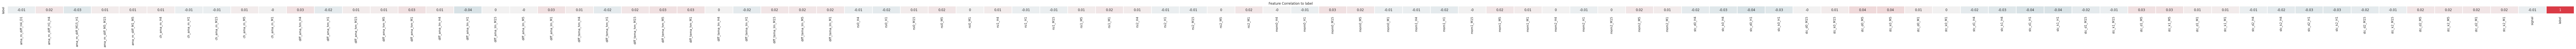

In [37]:
corrMat(df_tr1,'label',figsize=(170,0.5)) # Baseline Dataframe feature correlation to Signal

In [38]:
models = []
# Lightweight Models
models.append(('LDA', LinearDiscriminantAnalysis()))  # Unsupervised Model
models.append(('KNN', KNeighborsClassifier()))  # Unsupervised Model
models.append(('TREE', DecisionTreeClassifier())) # Supervised Model
models.append(('NB', GaussianNB())) # Unsupervised Model

# More Advanced Models
models.append(('GBM', GradientBoostingClassifier(n_estimators=55)))
models.append(('XGB',XGBClassifier(n_estimators=55,eval_metric='logloss')))
models.append(('CAT',CatBoostClassifier(silent=True,
                                        n_estimators=55)))
models.append(('RF', RandomForestClassifier(n_estimators=55)))


In [39]:
# eval_id (T/F): [CV,Train,Test,all]

def modelEval(ldf,feature='label',split_id=[None,None],eval_id=[True,True,True,True],
              n_fold=5,scoring='accuracy',plot_id=[False,True],cv_yrange=None,hm_vvals=[0.5,1.0,0.75]):

    print('Evaluation Function')
    print(f'Cross Validation Activated, n_splits : {n_fold}, scoring metric: {scoring}')
    if(eval_id[2]):
        if(split_id[0] is not None):
            print(f'Train/Evaluation Set Spit Activated: {split_id[0]}')
        if(split_id[1] is not None):
            print(f'Train/Evaluation Set Split made at {split_id[1]}')

    ''' 1. Split Train/Evaluation <DataFrame> Set Split '''

    # split_id : Train/Test split [%,timestamp], whichever is not None
    # test_id : Evaluate trained model on test set only

    if(split_id[0] is not None):
        # General Percentage Split (Non Shuffle requied for Time Series)
        train_df,eval_df = train_test_split(ldf,test_size=split_id[0],shuffle=False)
    elif(split_id[1] is not None):
        # specific time split
        train_df = df.loc[:split_id[1]]; eval_df = df.loc[split_id[1]:]
    else:
        print('Choose One Splitting Method Only')

    ''' 2. Train/Test Feature Matrices + Target Variables Split'''

    y_train = train_df[feature]
    X_train = train_df.loc[:, train_df.columns != feature]
    y_eval = eval_df[feature]
    X_eval = eval_df.loc[:, eval_df.columns != feature]
    X_one = pd.concat([X_train,X_eval],axis=0)
    y_one = pd.concat([y_train,y_eval],axis=0)

    print('');print(f'Using Features: {X_train.columns}')
    print(f'Target Variable: {feature}');print('')

    ''' 3. Visualise Training/Test Data'''
    if(plot_id[0]):

        # plot the training data
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=train_df.index, y=train_df['signal'],mode='lines',name='Training Data', line={'width': 0.25}))
        fig.update_layout(height=300,width=800,template='plotly_white',title='Training Signal Visualisation',
                          margin=dict(l=50,r=80,t=50,b=40))

        # Plot the test data as well
        if(eval_id[2]):
            fig.add_trace(go.Scatter(x=eval_df.index, y=eval_df['signal'],mode='lines',name='Test Data',line={'width': 0.25}))
            fig.update_layout(title='Training/Test Signal Visualisation')
        fig.show()

    ''' 4. Cross Validation, Training/Evaluation, one evaluation'''
    lst_res = []; names = []; lst_train = []; lst_eval = []; lst_one = []; lst_res_mean = []; trained_models = []
    if(any(eval_id)):
        for name, model in models:  # cycle through models & evaluate either cv or train/test
            names.append(name)
            print(name)

            # Cross Validation Model on Training Se
            if(eval_id[0]):
                t0=time.time()
                kfold = KFold(n_splits=n_fold)
                cv_res = cross_val_score(model,X_train,y_train, cv=kfold, scoring=scoring)
                t1 = time.time()
                lst_res.append(cv_res)
                tt1 = t1-t0 # total time for n_fold cross evaluation

            # Evaluate Fit Model on Training Data
            t2 = time.time()
            if(eval_id[1]):
                t2 = time.time()
                res = model.fit(X_train,y_train)
                train_res = accuracy_score(res.predict(X_train),y_train); lst_train.append(train_res)
            if(eval_id[2]):
                if(eval_id[1] is False):  # If training hasn't been called yet
                    res = model.fit(X_train,y_train)
                eval_res = accuracy_score(res.predict(X_eval),y_eval); lst_eval.append(eval_res)
            trained_models.append([name, res])
            t3 = time.time()
            tt2 = t3-t2 # total time for training/evaluation train/prediction

            # Evaluate model on entire dataset
            if(eval_id[3]):
                t4 = time.time()
                res = model.fit(X_one,y_one)
                one_res = accuracy_score(res.predict(X_one),y_one); lst_one.append(one_res)
                t5 = time.time()
                tt3 = t5-t4 # total time for training & evaluation on whole dataframe

            ''' [out] Verbal Outputs '''
            # Cross Validation / Training / Evaluation Model Evaluation / Section Times
            lst_res_mean.append(cv_res.mean())
            fn1 = cv_res.mean(); fn2 = cv_res.std();
            fn3 = train_res; fn4 = eval_res; fn5 = one_res
            print(f"{name} : {fn1:.3f}({fn2:.3f}) -> {tt1:.2f}s | {fn3:.3f} & {fn4:.3f} -> {tt2:.2f}s | {fn5:.3f} -> {tt3:.2}s")

    s0 = pd.Series(np.array(lst_res_mean),index=names)
    s1 = pd.Series(np.array(lst_train),index=names)
    s2 = pd.Series(np.array(lst_eval),index=names)
    s3 = pd.Series(np.array(lst_one),index=names)
    pdf = pd.concat([s0,s1,s2,s3],axis=1)
    pdf.columns = ['cv_average','train','test','all']
    s4 = pd.Series([tt1,tt2,tt3],index=['cv','train/test','all'])

    ''' 5. Visual Ouputs '''
    if(plot_id[1]):

        sns.set(style="whitegrid")
        fig,ax = plt.subplots(1,2,figsize=(15,4))
        ax[0].set_title(f'{n_fold} Cross Validation Results')
        sns.boxplot(data=lst_res, ax=ax[0], orient="v",width=0.3)
        ax[0].set_xticklabels(names)
        sns.stripplot(data=lst_res,ax=ax[0], orient='v',color=".3",linewidth=1)
        ax[0].set_xticklabels(names)
        ax[0].xaxis.grid(True)
        ax[0].set(xlabel="")
        if(cv_yrange is not None):
            ax[0].set_ylim(cv_yrange)
        sns.despine(trim=True, left=True)

        sns.heatmap(pdf,vmin=hm_vvals[0],vmax=hm_vvals[1],center=hm_vvals[2],
                    ax=ax[1],square=False,lw=2,annot=True,fmt='.3f',cmap='Blues')
        ax[1].set_title('Accuracy Scores')
        plt.show()
    return trained_models



Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index(['ama_m_diff_H4_D1', 'ama_m_diff_H1_H4', 'ama_m_diff_M15_H1',
       'ama_m_diff_M5_M15', 'ama_m_diff_M1_M5', 'ch_ama_m_H4', 'ch_ama_m_H1',
       'ch_ama_m_M15', 'ch_ama_m_M5', 'ch_ama_m_M1', 'diff_ama_hm_H4',
       'diff_ama_hm_H1', 'diff_ama_hm_M15', 'diff_ama_hm_M5', 'diff_ama_hm_M1',
       'diff_ama_lm_H4', 'diff_ama_lm_H1', 'diff_ama_lm_M15', 'diff_ama_lm_M5',
       'diff_ama_lm_M1', 'diff_tema_hm_H4', 'diff_tema_hm_H1',
       'diff_tema_hm_M15', 'diff_tema_hm_M5', 'diff_tema_hm_M1',
       'diff_tema_lm_H4', 'diff_tema_lm_H1', 'diff_tema_lm_M15',
       'diff_tema_lm_M5', 'diff_tema_lm_M1', 'rsi0_H4', 'rsi0_H1', 'rsi0_M15',
       'rsi0_M5', 'rsi0_M1', 'rsi1_H4', 'rsi1_H1', 'rsi1_M15', 'rsi1_M5',
       'rsi1_M1', 'rsi2_H4', 'rsi2_H1', 'rsi2_M15', 'rsi2_M5', 'rsi2_M1',
       'mom0_H4', 'mom0_H1', 'mom0_M15', 'mom0_M5', 'mom0_

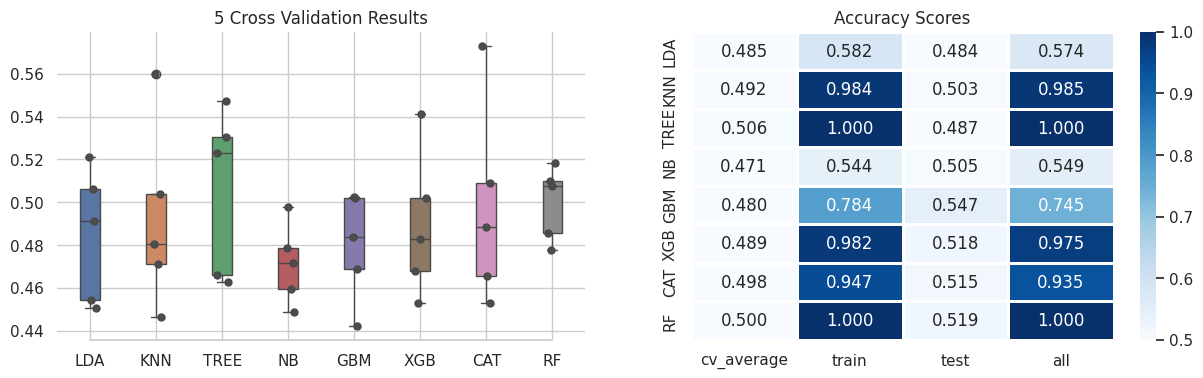

In [40]:
# Останній (поточний)
trained_models1 = modelEval(df_tr1,split_id=[0.2,None],plot_id=[False,True])

# **Зберігаєм натреновані моделі**

In [61]:
df_tr1.iloc[47, df_tr1.columns != 'label'].values

array([-2747,     0,  -246,   -61,   -46,   -76,   -13,    -1,     0,
           0,   378,  -108,    54,    17,    14,    73,  -156,   -88,
         -66,   -14,  -215,  -183,   -24,   -30,   -15,  -504,  -483,
        -180,   -63,   -29,    24,    38,    40,    39,    32,    24,
          38,    41,    42,    40,    24,    38,    42,    42,    43,
          48,    84,    87,    97,    97,    39,    92,    77,    95,
          95,    21,    55,   103,    87,    93,    19,    16,    35,
          20,    30,    36,    53,    44,    19,    23,    17,    13,
          33,    20,    20,    22,    55,    50,    14,    14,    13,
          11,    20,    16,    22,    22,    50,    46,    12,    12,
          21,     0], dtype=int16)

In [69]:
# trained_models1[0][1].predict(df_tr1.loc[2300, df_tr1.columns != 'label'].values.reshape(1, -1))
# look on df_te1
print('label\t','predict')
for i in range(100,140):
  myiloc = i#*(-1)
  # print(df_tr1.iloc[myiloc]['label'])
  # print(trained_models1[4][1].predict(df_tr1.iloc[myiloc, df_tr1.columns != 'label'].values.reshape(1, -1)))
  print(df_te1.iloc[myiloc]['label'],'\t',trained_models1[0][1].predict(df_te1.iloc[myiloc, df_te1.columns != 'label'].values.reshape(1, -1)))


label	 predict
0 	 [0]
0 	 [0]
1 	 [0]
1 	 [0]
1 	 [0]
1 	 [0]
1 	 [0]
1 	 [0]
1 	 [0]
1 	 [0]
1 	 [0]
1 	 [0]
1 	 [0]
1 	 [0]
0 	 [0]
0 	 [0]
0 	 [0]
0 	 [0]
1 	 [0]
1 	 [0]
0 	 [0]
1 	 [0]
0 	 [0]
0 	 [0]
0 	 [0]
0 	 [0]
0 	 [1]
1 	 [0]
1 	 [0]
1 	 [0]
1 	 [0]
1 	 [0]
1 	 [0]
1 	 [0]
1 	 [0]
1 	 [0]
1 	 [0]
1 	 [0]
1 	 [0]
1 	 [0]


In [ ]:
import pickle

# Save to file
with open('models_pickle', 'wb') as f:
    pickle.dump(trained_models, f)

# load from file
with open('models_pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    trained_models1_loaded = pickle.load(f)

Це що далі закоментовано не мало позитивного впливу
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

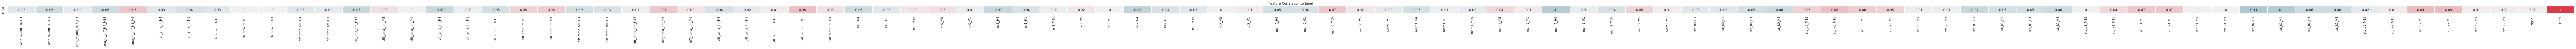

In [ ]:
# # на останньому (поточний)
# corrMat(df_tr1,'label',figsize=(170,0.5)) # Baseline Dataframe feature correlation to Signal

In [ ]:
# toDrop=corrMat(df_tr1,'label',figsize=(170,0.5),ret_id=True)
# toDrop

ama_m_diff_H4_D1  ama_m_diff_H1_H4  ama_m_diff_M15_H1  \
label             -0.03             -0.06              -0.02   

       ama_m_diff_M5_M15  ama_m_diff_M1_M5  ch_ama_m_H4  ch_ama_m_H1  \
label              -0.06              0.07        -0.03        -0.04   

       ch_ama_m_M15  ch_ama_m_M5  ch_ama_m_M1  ...  stc_d2_H1  stc_k2_H1  \
label         -0.03          0.0          0.0  ...      -0.06      -0.06   

       stc_d2_M15  stc_k2_M15  stc_d2_M5  stc_k2_M5  stc_d2_M1  stc_k2_M1  \
label       -0.02        0.01       0.09       0.09       0.01       0.01   

       signal  label  
label    0.01    1.0  

[1 rows x 92 columns]

In [ ]:
# # Condition to drop columns where toDrop[column] < 0.01
# columns_to_drop = toDrop.columns[toDrop.iloc[0] < 0.01]

# # Drop columns from df1 based on the condition
# df_tr1 = df_tr1.drop(columns=columns_to_drop)

# df_tr1


diff_ama_hm_M1  diff_ama_lm_M1  \
2015-01-07 12:00:26.802000046               1             -52   
2015-01-07 12:00:28.628999949               0             -54   
2015-01-07 12:00:51.471999884               2             -57   
2015-01-07 12:01:00.665999889               2             -57   
2015-01-07 12:01:01.665999889               2             -57   
...                                       ...             ...   
2015-03-05 17:42:04.674999952              28               8   
2015-03-05 17:43:44.693000078              29               8   
2015-03-05 17:43:56.325999975              29               8   
2015-03-05 17:44:02.789999962              29               8   
2015-03-05 17:44:42.558000088              29               2   

                               diff_tema_hm_M5  diff_tema_hm_M1  \
2015-01-07 12:00:26.802000046              -75              -18   
2015-01-07 12:00:28.628999949              -61               -4   
2015-01-07 12:00:51.471999884               -1               58   
2015-01-07 12:01:00.665999889               -1               28   
2015-01-07 12:01:01.665999889               -1               30   
...                                        ...              ...   
2015-03-05 17:42:04.674999952              -24                3   
2015-03-05 17:43:44.693000078              -24                2   
2015-03-05 17:43:56.325999975              -24                5   
2015-03-05 17:44:02.789999962              -24               14   
2015-03-05 17:44:42.558000088              -24               15   

                               diff_tema_lm_M5  diff_tema_lm_M1  rsi0_M15  \
2015-01-07 12:00:26.802000046             -151              -77        37   
2015-01-07 12:00:28.628999949             -153              -79        41   
2015-01-07 12:00:51.471999884             -160              -82        47   
2015-01-07 12:01:00.665999889             -160              -28        38   
2015-01-07 12:01:01.665999889             -160              -28        39   
...                                        ...              ...       ...   
2015-03-05 17:42:04.674999952              -67               -5        52   
2015-03-05 17:43:44.693000078              -90              -23        52   
2015-03-05 17:43:56.325999975              -90              -23        53   
2015-03-05 17:44:02.789999962              -90               -1        53   
2015-03-05 17:44:42.558000088              -97              -44        47   

                               rsi0_M5  rsi1_M5  rsi1_M1  ...  stc_d0_M1  \
2015-01-07 12:00:26.802000046       42       38       50  ...         35   
2015-01-07 12:00:28.628999949       48       42       55  ...         37   
2015-01-07 12:00:51.471999884       56       47       61  ...         35   
2015-01-07 12:01:00.665999889       43       39       52  ...         32   
2015-01-07 12:01:01.665999889       44       40       52  ...         32   
...                                ...      ...      ...  ...        ...   
2015-03-05 17:42:04.674999952       52       52       44  ...         16   
2015-03-05 17:43:44.693000078       54       53       46  ...         23   
2015-03-05 17:43:56.325999975       56       53       48  ...         24   
2015-03-05 17:44:02.789999962       56       53       48  ...         37   
2015-03-05 17:44:42.558000088       40       47       36  ...         27   

                               stc_d1_M5  stc_k1_M5  stc_d1_M1  stc_k1_M1  \
2015-01-07 12:00:26.802000046         13         16         25         33   
2015-01-07 12:00:28.628999949         15         19         28         40   
2015-01-07 12:00:51.471999884         17         23         28         39   
2015-01-07 12:01:00.665999889         14         16         28         34   
2015-01-07 12:01:01.665999889         14         17         28         35   
...                                  ...        ...        ...        ...   
2015-03-05 17:42:04.674999952         79         77         36      

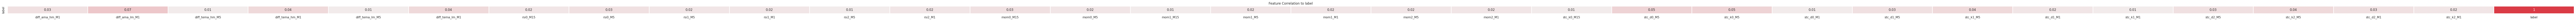

In [ ]:
# corrMat(df_tr1,'label',figsize=(170,0.5)) # Baseline Dataframe feature correlation to Signal

Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index(['diff_ama_hm_M1', 'diff_ama_lm_M1', 'diff_tema_hm_M5',
       'diff_tema_hm_M1', 'diff_tema_lm_M5', 'diff_tema_lm_M1', 'rsi0_M15',
       'rsi0_M5', 'rsi1_M5', 'rsi1_M1', 'rsi2_M5', 'rsi2_M1', 'mom0_M15',
       'mom0_M5', 'mom1_M15', 'mom1_M5', 'mom1_M1', 'mom2_M5', 'mom2_M1',
       'stc_k0_M15', 'stc_d0_M5', 'stc_k0_M5', 'stc_d0_M1', 'stc_d1_M5',
       'stc_k1_M5', 'stc_d1_M1', 'stc_k1_M1', 'stc_d2_M5', 'stc_k2_M5',
       'stc_d2_M1', 'stc_k2_M1'],
      dtype='object')
Target Variable: label

LDA
LDA : 0.488(0.011) -> 0.23s | 0.557 & 0.517 -> 0.13s | 0.554 -> 0.12s
KNN
KNN : 0.484(0.014) -> 4.77s | 0.939 & 0.484 -> 7.42s | 0.938 -> 8.8s
TREE
TREE : 0.496(0.018) -> 2.09s | 1.000 & 0.501 -> 0.51s | 1.000 -> 0.64s
NB
NB : 0.478(0.016) -> 0.05s | 0.520 & 0.510 -> 0.01s | 0.532 -> 0.014s
GBM
GBM : 0.486(0.011) -> 20.72s | 0.684 & 0.480

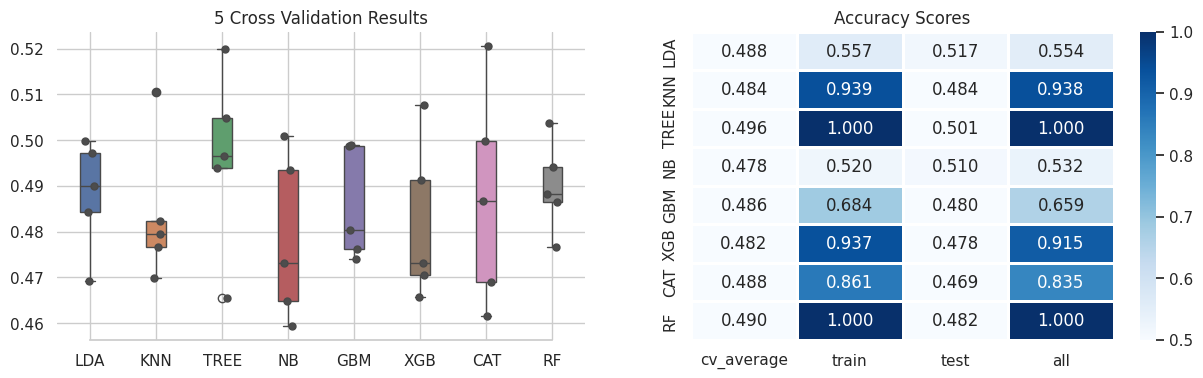

In [ ]:
# # на останньому (поточний)
# modelEval(df_tr1,split_id=[0.2,None],plot_id=[False,True])

кінець закоментованого блоку
________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# **Останній сформований**

In [ ]:
# для вибору поточного значення  -1
# для вибору останнього сформованого значення  -2
takeBar = -2

# добавим данні з numpy ndarray в df
for colName in meta['columns']:
    f_signals[colName] = np_data_s[:, meta['columns'].index(colName), takeBar]

print(len(f_signals))
f_signals.head()

140661


f1  ama_m_diff_H4_D1  ama_m_diff_H1_H4  \
f0                                                                      
2015-01-07 12:00:26.802000046  12             -2671               -62   
2015-01-07 12:00:28.628999949  21             -2671               -62   
2015-01-07 12:00:51.471999884  31             -2671               -62   
2015-01-07 12:01:00.665999889  12             -2671               -62   
2015-01-07 12:01:01.665999889  13             -2671               -62   

                               ama_m_diff_M15_H1  ama_m_diff_M5_M15  \
f0                                                                    
2015-01-07 12:00:26.802000046               -256                -59   
2015-01-07 12:00:28.628999949               -256                -59   
2015-01-07 12:00:51.471999884               -256                -59   
2015-01-07 12:01:00.665999889               -256                -59   
2015-01-07 12:01:01.665999889               -256                -59   

                               ama_m_diff_M1_M5  ch_ama_m_H4  ch_ama_m_H1  \
f0                                                                          
2015-01-07 12:00:26.802000046               -76          -71          -14   
2015-01-07 12:00:28.628999949               -76          -71          -14   
2015-01-07 12:00:51.471999884               -76          -71          -14   
2015-01-07 12:01:00.665999889               -72          -71          -14   
2015-01-07 12:01:01.665999889               -72          -71          -14   

                               ch_ama_m_M15  ch_ama_m_M5  ...  stc_d2_H4  \
f0                                                        ...              
2015-01-07 12:00:26.802000046            -4          -16  ...         15   
2015-01-07 12:00:28.628999949            -4          -16  ...         15   
2015-01-07 12:00:51.471999884            -4          -16  ...         15   
2015-01-07 12:01:00.665999889            -4          -16  ...         15   
2015-01-07 12:01:01.665999889            -4          -16  ...         15   

                               stc_k2_H4  stc_d2_H1  stc_k2_H1  stc_d2_M15  \
f0                                                                           
2015-01-07 12:00:26.802000046         13         24         23          26   
2015-01-07 12:00:28.628999949         13         24         23          26   
2015-01-07 12:00:51.471999884         13         24         23          26   
2015-01-07 12:01:00.665999889         13         24         23          26   
2015-01-07 12:01:01.665999889         13         24         23          26   

                               stc_k2_M15  stc_d2_M5  stc_k2_M5  stc_d2_M1  \
f0                                                                           
2015-01-07 12:00:26.802000046          16         11          8         14   
2015-01-07 12:00:28.628999949          16         11          8         14   
2015-01-07 12:00:51.471999884          16         11          8         14   
2015-01-07 12:01:00.665999889          16         11          8         18   
2015-01-07 12:01:01.665999889          16         11          8         18   

                               stc_k2_M1  
f0                                        
2015-01-07 12:00:26.802000046         11  
2015-01-07 12:00:28.628999949         11  
2015-01-07 12:00:51.471999884         11  
2015-01-07 12:01:00.665999889         22  
2015-01-07 12:01:01.665999889         22  

[5 rows x 91 columns]

In [ ]:
# Обєднання датафреймів по індексу
result2 = pd.merge(f_signals, f_labels, left_index=True, right_index=True, how='inner')
result2.drop(result2.columns[0], axis=1, inplace=True) # видалення колонки 'f1' з номером сигналу (дублюється f_signals[f1]=f_labels[signal])
print(len(result2))
result2.head()

140658


ama_m_diff_H4_D1  ama_m_diff_H1_H4  \
2015-01-07 12:00:26.802000046             -2671               -62   
2015-01-07 12:00:28.628999949             -2671               -62   
2015-01-07 12:00:51.471999884             -2671               -62   
2015-01-07 12:01:00.665999889             -2671               -62   
2015-01-07 12:01:01.665999889             -2671               -62   

                               ama_m_diff_M15_H1  ama_m_diff_M5_M15  \
2015-01-07 12:00:26.802000046               -256                -59   
2015-01-07 12:00:28.628999949               -256                -59   
2015-01-07 12:00:51.471999884               -256                -59   
2015-01-07 12:01:00.665999889               -256                -59   
2015-01-07 12:01:01.665999889               -256                -59   

                               ama_m_diff_M1_M5  ch_ama_m_H4  ch_ama_m_H1  \
2015-01-07 12:00:26.802000046               -76          -71          -14   
2015-01-07 12:00:28.628999949               -76          -71          -14   
2015-01-07 12:00:51.471999884               -76          -71          -14   
2015-01-07 12:01:00.665999889               -72          -71          -14   
2015-01-07 12:01:01.665999889               -72          -71          -14   

                               ch_ama_m_M15  ch_ama_m_M5  ch_ama_m_M1  ...  \
2015-01-07 12:00:26.802000046            -4          -16          -12  ...   
2015-01-07 12:00:28.628999949            -4          -16          -12  ...   
2015-01-07 12:00:51.471999884            -4          -16          -12  ...   
2015-01-07 12:01:00.665999889            -4          -16            0  ...   
2015-01-07 12:01:01.665999889            -4          -16            0  ...   

                               stc_d2_H1  stc_k2_H1  stc_d2_M15  stc_k2_M15  \
2015-01-07 12:00:26.802000046         24         23          26          16   
2015-01-07 12:00:28.628999949         24         23          26          16   
2015-01-07 12:00:51.471999884         24         23          26          16   
2015-01-07 12:01:00.665999889         24         23          26          16   
2015-01-07 12:01:01.665999889         24         23          26          16   

                               stc_d2_M5  stc_k2_M5  stc_d2_M1  stc_k2_M1  \
2015-01-07 12:00:26.802000046         11          8         14         11   
2015-01-07 12:00:28.628999949         11          8         14         11   
2015-01-07 12:00:51.471999884         11          8         14         11   
2015-01-07 12:01:00.665999889         11          8         18         22   
2015-01-07 12:01:01.665999889         11          8         18         22   

                               signal  label  
2015-01-07 12:00:26.802000046      12      1  
2015-01-07 12:00:28.628999949      21      1  
2015-01-07 12:00:51.471999884      31     -1  
2015-01-07 12:01:00.665999889      12      1  
2015-01-07 12:01:01.665999889      13      1  

[5 rows x 92 columns]

In [ ]:
# підготуєм df2 для тренування 100 000
df2 = result2.iloc[:100000]
print(df2.label.value_counts())        # absolute
df2.label.value_counts()/len(df2)       # %


label
 1    7209
-1    6785
 0    6006
Name: count, dtype: int64


label
 1    0.36045
-1    0.33925
 0    0.30030
Name: count, dtype: float64

In [ ]:
df2_0 = pd.DataFrame(columns=df2.columns)  # df for save '0' labels

# Define the condition to move records
condition = df2['label'] == 0  # Example condition: Select rows where 'label'==0

# Move records from df to df0 based on the condition
df2_0 = pd.concat([df2_0, df2[condition]])

# Remove the moved records from df
df2 = df2[~condition]

# Output the result
print('df2_0--------------\n',df2_0.label.value_counts())
print('df2--------------\n',df2.label.value_counts())

df2_0--------------
 label
0    6006
Name: count, dtype: int64
df2--------------
 label
 1    7209
-1    6785
Name: count, dtype: int64


In [ ]:
# Replacing 'label' with 0 in the 'label' column
df2['label'].mask(df2['label'] == -1, 0, inplace=True)
print('df2_0--------------\n',df2_0.label.value_counts())
print('df2--------------\n',df2.label.value_counts())

df2_0--------------
 label
0    6006
Name: count, dtype: int64
df2--------------
 label
1    7209
0    6785
Name: count, dtype: int64


In [ ]:
display(df2['label'].value_counts())

# print()

# df1['signal'] = np.where(df1['result'] == 0 , -1.0, np.where(df1['result'] < 7 , 0.0, 1.0)) # Create signals
# df1 = df1.drop(columns=['result'])
# display(df1['signal'].value_counts())



label
1    7209
0    6785
Name: count, dtype: int64

In [ ]:
# df_tr,df_te = TimeSeries_Split(df,split_id=[0.2,None], #  Train/Test Split (0.8/0.2)
#                                cut_id=data_period)     # Use only 100,000 data points

df_tr2,df_te2 = TimeSeries_Split(df2,split_id=[0.2,None]) #  Train/Test Split (0.8/0.2)
                              #  cut_id=data_period)     # Use only 100,000 data points


Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index(['ama_m_diff_H4_D1', 'ama_m_diff_H1_H4', 'ama_m_diff_M15_H1',
       'ama_m_diff_M5_M15', 'ama_m_diff_M1_M5', 'ch_ama_m_H4', 'ch_ama_m_H1',
       'ch_ama_m_M15', 'ch_ama_m_M5', 'ch_ama_m_M1', 'diff_ama_hm_H4',
       'diff_ama_hm_H1', 'diff_ama_hm_M15', 'diff_ama_hm_M5', 'diff_ama_hm_M1',
       'diff_ama_lm_H4', 'diff_ama_lm_H1', 'diff_ama_lm_M15', 'diff_ama_lm_M5',
       'diff_ama_lm_M1', 'diff_tema_hm_H4', 'diff_tema_hm_H1',
       'diff_tema_hm_M15', 'diff_tema_hm_M5', 'diff_tema_hm_M1',
       'diff_tema_lm_H4', 'diff_tema_lm_H1', 'diff_tema_lm_M15',
       'diff_tema_lm_M5', 'diff_tema_lm_M1', 'rsi0_H4', 'rsi0_H1', 'rsi0_M15',
       'rsi0_M5', 'rsi0_M1', 'rsi1_H4', 'rsi1_H1', 'rsi1_M15', 'rsi1_M5',
       'rsi1_M1', 'rsi2_H4', 'rsi2_H1', 'rsi2_M15', 'rsi2_M5', 'rsi2_M1',
       'mom0_H4', 'mom0_H1', 'mom0_M15', 'mom0_M5', 'mom0_

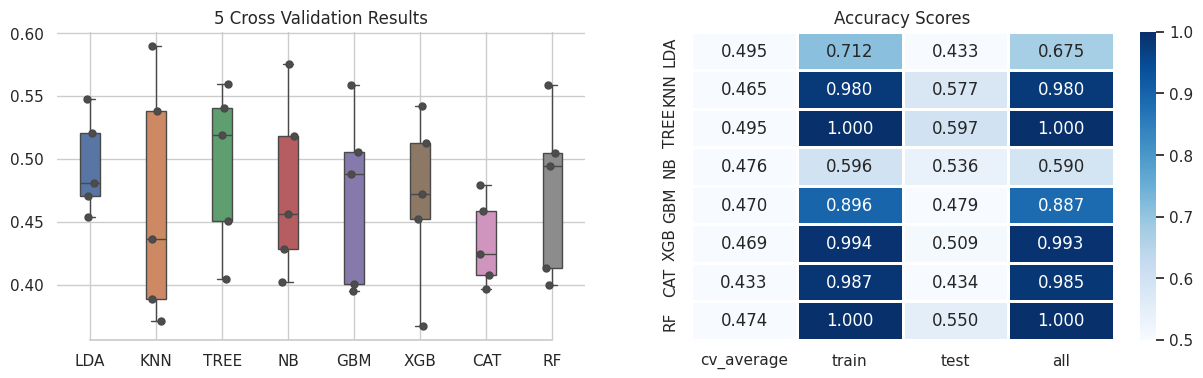

In [ ]:
# на передостанньому (останній сформований)
modelEval(df_tr2,split_id=[0.2,None],plot_id=[False,True])

Закоментований блок (нема позитивного впливу)
________________________________________________________________________________________________________________________________________________________________

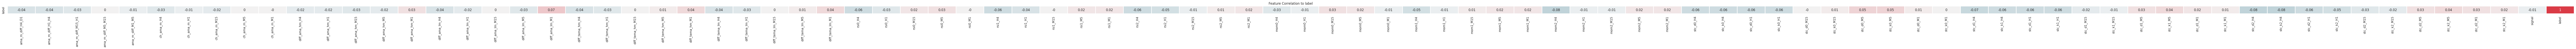

In [ ]:
# # на передостанньому
# corrMat(df_tr2,'label',figsize=(170,0.5)) # Baseline Dataframe feature correlation to Signal

In [ ]:
# toDrop=corrMat(df_tr2,'label',figsize=(170,0.5),ret_id=True)
# toDrop

ama_m_diff_H4_D1  ama_m_diff_H1_H4  ama_m_diff_M15_H1  \
label             -0.05             -0.05              -0.03   

       ama_m_diff_M5_M15  ama_m_diff_M1_M5  ch_ama_m_H4  ch_ama_m_H1  \
label                0.0             -0.01        -0.02         -0.0   

       ch_ama_m_M15  ch_ama_m_M5  ch_ama_m_M1  ...  stc_d2_H1  stc_k2_H1  \
label         -0.02         0.01         0.01  ...      -0.06      -0.06   

       stc_d2_M15  stc_k2_M15  stc_d2_M5  stc_k2_M5  stc_d2_M1  stc_k2_M1  \
label       -0.04       -0.03       0.02       0.03       0.04       0.03   

       signal  label  
label   -0.01    1.0  

[1 rows x 92 columns]

In [ ]:
# # Condition to drop columns where toDrop[column] < 0.01
# columns_to_drop = toDrop.columns[toDrop.iloc[0] < 0.01]

# # Drop columns from df1 based on the condition
# df_tr2 = df_tr2.drop(columns=columns_to_drop)

# # df_tr2


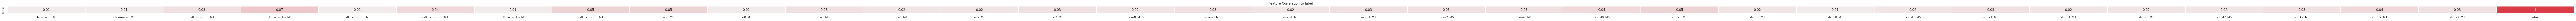

In [ ]:
# corrMat(df_tr2,'label',figsize=(170,0.5)) # Baseline Dataframe feature correlation to Signal

Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index(['ch_ama_m_M5', 'ch_ama_m_M1', 'diff_ama_hm_M1', 'diff_ama_lm_M1',
       'diff_tema_hm_M5', 'diff_tema_hm_M1', 'diff_tema_lm_M5',
       'diff_tema_lm_M1', 'rsi0_M5', 'rsi0_M1', 'rsi1_M5', 'rsi1_M1',
       'rsi2_M5', 'rsi2_M1', 'mom0_M15', 'mom0_M5', 'mom1_M5', 'mom1_M1',
       'mom2_M5', 'mom2_M1', 'stc_d0_M5', 'stc_k0_M5', 'stc_d0_M1',
       'stc_k0_M1', 'stc_d1_M5', 'stc_k1_M5', 'stc_d1_M1', 'stc_k1_M1',
       'stc_d2_M5', 'stc_k2_M5', 'stc_d2_M1', 'stc_k2_M1'],
      dtype='object')
Target Variable: label

LDA
LDA : 0.487(0.016) -> 0.33s | 0.559 & 0.486 -> 0.07s | 0.556 -> 0.12s
KNN
KNN : 0.492(0.020) -> 4.77s | 0.924 & 0.495 -> 6.48s | 0.923 -> 8.4s
TREE
TREE : 0.504(0.029) -> 1.71s | 0.992 & 0.499 -> 0.46s | 0.992 -> 0.66s
NB
NB : 0.479(0.008) -> 0.05s | 0.528 & 0.512 -> 0.01s | 0.533 -> 0.015s
GBM
GBM : 0.479(0.025) -> 20.61s

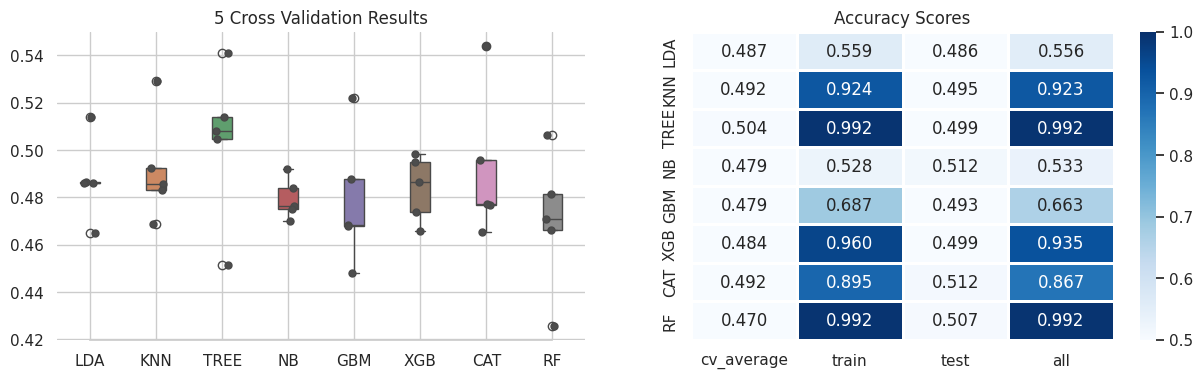

In [ ]:
# на передостанньому (сформований)
modelEval(df_tr2,split_id=[0.2,None],plot_id=[False,True])

## **5.1 | Dimensionality reduction via feature importance**

    We can look at the Feature Importance (FI) of certain trained models to understand which features & to what extent.
    We can use such minimalistic functions to quicky evaluat feature importance by relying on variation of approaches & optimised libraries.
    We can obtain relative feature importance using different libraries , function feature_importance includes:


In [ ]:
from sklearn.feature_selection import SelectKBest,f_regression
from xgboost import plot_importance,XGBRegressor
from catboost import CatBoostClassifier,CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
import shap
import seaborn as sns

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot Correlation to Target Variable only
def corrMat(df,target='label',figsize=(9,0.5),ret_id=False):

    corr_mat = df.corr().round(2)
    shape = corr_mat.shape[0]
    corr_mat = corr_mat.transpose()
    corr = corr_mat.loc[:, df.columns == target].transpose().copy()

    if(ret_id):
        return corr

''' Feature Importance '''
# Various Approaches for quick FI evaluation

# def fi(ldf,target='label',n_est=25,num_only=True,
      #  drop_id=None,target_cat=True,drop_na=False):

def fi(ldf,target='label',n_est=25,num_only=True,
       drop_id=None,target_cat=False,drop_na=False):

    # Select only numerical features
    if(num_only):
        ldf = ldf.select_dtypes(include=['float64','int16','int8'])

    # Drop all NaN
    if(drop_na):
        print(f'Before NaN drop: {ldf.shape}')
        ldf = ldf.dropna()
        print(f'After NaN dropped: {ldf.shape}')


    ldf = ldf.copy()
    # If target is categorical string variable
    if(target_cat):
        cats = ldf[target].unique()
        cats_id = [i for i in range(0,len(cats))]
        maps = dict(zip(cats,cats_id))
        ldf[target] = ldf[target].map(maps)

    # If any features are desired to be droped
    if(drop_id is not None):
        ldf = ldf.drop(drop_id,axis=1)

    # Input dataframe containing feature & target variable
    y = ldf[target]
    X = ldf.drop(target,axis=1)

#   CORRELATION
    imp = corrMat(ldf,target,figsize=(15,0.5),ret_id=True)
    del imp[target]
    s1 = imp.squeeze(axis=0);s1 = abs(s1)
    s1.name = 'CORR'

#   SHAP
    model = CatBoostRegressor(silent=True,n_estimators=n_est).fit(X,y)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap_sum = np.abs(shap_values).mean(axis=0)
    s2 = pd.Series(shap_sum,index=X.columns,name='CAT_SHAP').T

#   CATBOOST
    model = CatBoostRegressor(silent=True,n_estimators=n_est).fit(X,y)
    fit = model.fit(X,y)
    rf_fi = pd.DataFrame(model.feature_importances_,index=X.columns,
                                         columns=['CAT'])
    rf_fi.sort_values('CAT',ascending=False)
    s3 = rf_fi.T.squeeze(axis=0)

#   RANDOMFOREST
    model = RandomForestRegressor(n_est,random_state=0, n_jobs=-1)
    fit = model.fit(X,y)
    rf_fi = pd.DataFrame(model.feature_importances_,index=X.columns,
                                         columns=['RF'])
    rf_fi.sort_values('RF',ascending=False)
    s4 = rf_fi.T.squeeze(axis=0)

#   XGB
    model=XGBRegressor(n_estimators=n_est,learning_rate=0.5,verbosity = 0)
    model.fit(X,y)
    data = model.feature_importances_
    s5 = pd.Series(data,index=X.columns,name='XGB').T

#   KBEST
    model = SelectKBest(k=5, score_func=f_regression)
    fit = model.fit(X,y)
    data = fit.scores_
    s6 = pd.Series(data,index=X.columns,name='KBEST')

    # Combine Scores
    df0 = pd.concat([s1,s2,s3,s4,s5,s6],axis=1)
    df0.rename(columns={'target':'lin corr'})

    # MinMax Scaler
    x = df0.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled,index=df0.index,columns=df0.columns)
    df = df.rename_axis(f'<b>FI APPROACH</b>', axis=1)
    df = df.rename_axis('Feature', axis=0)

    pd.options.plotting.backend = "plotly"
    fig = df.plot(kind='bar',title='<b>SCALED FEATURE IMPORTANCE</b>',
                  color_discrete_sequence=px.colors.qualitative.T10)
    fig.update_layout(template='plotly_white',height=400,
                     font=dict(family='sans-serif',size=12),
                     margin=dict(l=60, r=40, t=50, b=10))
    fig.update_traces(width=0.25)
    fig.show()

In [ ]:
fi(df_tr1)

In [ ]:
df_tr1_FI = df_tr1.drop(columns=['ch_ama_m_M1','rsi0_M1','rsi1_M1','mom1_M1','mom2_M1','stc_d0_M1','stc_k0_M1','stc_d1_M1','stc_k1_M1','stc_d2_M1','stc_k2_M1','signal'])


Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index(['ama_m_diff_H4_D1', 'ama_m_diff_H1_H4', 'ama_m_diff_M15_H1',
       'ama_m_diff_M5_M15', 'ama_m_diff_M1_M5', 'ch_ama_m_H4', 'ch_ama_m_H1',
       'ch_ama_m_M15', 'ch_ama_m_M5', 'diff_ama_hm_H4', 'diff_ama_hm_H1',
       'diff_ama_hm_M15', 'diff_ama_hm_M5', 'diff_ama_hm_M1', 'diff_ama_lm_H4',
       'diff_ama_lm_H1', 'diff_ama_lm_M15', 'diff_ama_lm_M5', 'diff_ama_lm_M1',
       'diff_tema_hm_H4', 'diff_tema_hm_H1', 'diff_tema_hm_M15',
       'diff_tema_hm_M5', 'diff_tema_hm_M1', 'diff_tema_lm_H4',
       'diff_tema_lm_H1', 'diff_tema_lm_M15', 'diff_tema_lm_M5',
       'diff_tema_lm_M1', 'rsi0_H4', 'rsi0_H1', 'rsi0_M15', 'rsi0_M5',
       'rsi1_H4', 'rsi1_H1', 'rsi1_M15', 'rsi1_M5', 'rsi2_H4', 'rsi2_H1',
       'rsi2_M15', 'rsi2_M5', 'rsi2_M1', 'mom0_H4', 'mom0_H1', 'mom0_M15',
       'mom0_M5', 'mom0_M1', 'mom1_H4', 'mom1_H1', 'mom1_M15'

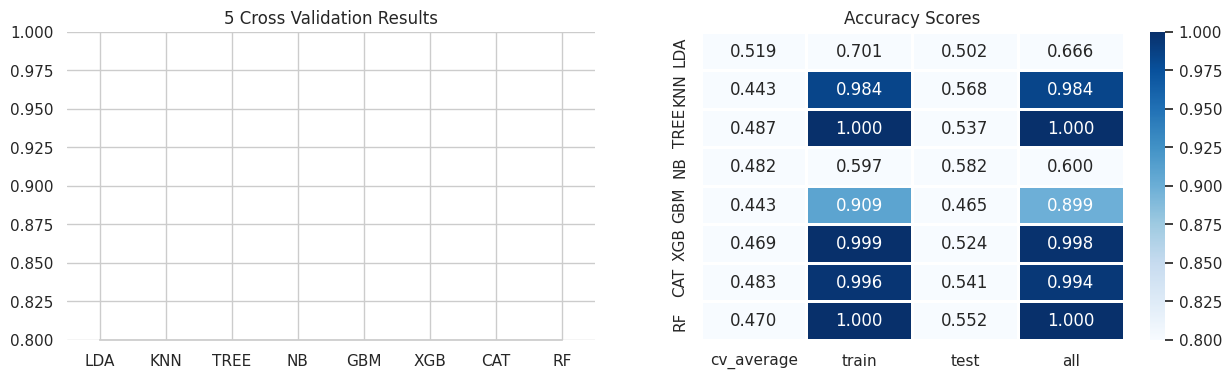

In [ ]:
modelEval(df_tr1_FI,split_id=[0.2,None],plot_id=[False,True],cv_yrange=(0.8,1.0),hm_vvals=[0.8,1.0,0.9])


In [ ]:
fi(df_tr2)

In [ ]:
df_tr2_FI = df_tr2.drop(columns=['ch_ama_m_M1','mom0_M1','stc_d0_M1','stc_k0_M1','stc_d1_M1','stc_k1_M1','stc_d2_M1','stc_k2_M1','signal'])


In [ ]:
# df_tr2.info()


Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index(['ama_m_diff_H4_D1', 'ama_m_diff_H1_H4', 'ama_m_diff_M15_H1',
       'ama_m_diff_M5_M15', 'ama_m_diff_M1_M5', 'ch_ama_m_H4', 'ch_ama_m_H1',
       'ch_ama_m_M15', 'ch_ama_m_M5', 'diff_ama_hm_H4', 'diff_ama_hm_H1',
       'diff_ama_hm_M15', 'diff_ama_hm_M5', 'diff_ama_hm_M1', 'diff_ama_lm_H4',
       'diff_ama_lm_H1', 'diff_ama_lm_M15', 'diff_ama_lm_M5', 'diff_ama_lm_M1',
       'diff_tema_hm_H4', 'diff_tema_hm_H1', 'diff_tema_hm_M15',
       'diff_tema_hm_M5', 'diff_tema_hm_M1', 'diff_tema_lm_H4',
       'diff_tema_lm_H1', 'diff_tema_lm_M15', 'diff_tema_lm_M5',
       'diff_tema_lm_M1', 'rsi0_H4', 'rsi0_H1', 'rsi0_M15', 'rsi0_M5',
       'rsi0_M1', 'rsi1_H4', 'rsi1_H1', 'rsi1_M15', 'rsi1_M5', 'rsi1_M1',
       'rsi2_H4', 'rsi2_H1', 'rsi2_M15', 'rsi2_M5', 'rsi2_M1', 'mom0_H4',
       'mom0_H1', 'mom0_M15', 'mom0_M5', 'mom1_H4', 'mom1_H1',

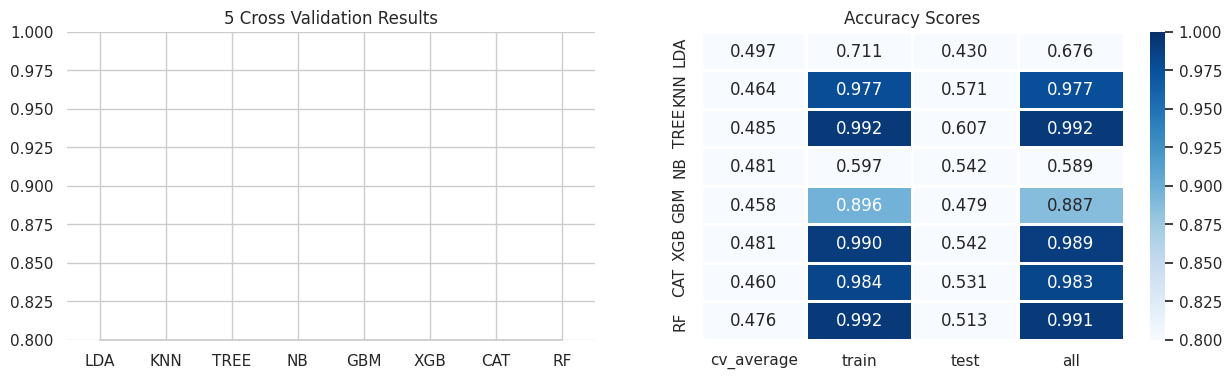

In [ ]:
modelEval(df_tr2_FI,split_id=[0.2,None],plot_id=[False,True],cv_yrange=(0.8,1.0),hm_vvals=[0.8,1.0,0.9])



# **5.2 | Dimensionality reduction using unsupervised learning algorithms**

In [ ]:
def dimRed(ldf,feature='label',split_id=[None,None],n_comp=5,plot_id=True,
           model_id='sparserandomprojection',scaler_id=[False,None]):

    # Given a dataframe, split feature/target variable
    X = ldf.copy()
    y = ldf[feature].copy()
    del X[feature]

    n_jobs = -1; rs = 32

    if(model_id is 'pca'):
        whiten = False
        model = PCA(n_components=n_comp,whiten=whiten,random_state=rs)
    if(model_id is 'sparsepca'):
        alpha = 1
        model = SparsePCA(n_components=n_comp,alpha=alpha,random_state=rs,n_jobs=n_jobs)
    elif(model_id is 'kernelpca'):
        kernel = 'rbf'; gamma = None
        model = KernelPCA(n_components=n_comp,kernel=kernel,gamma=gamma,n_jobs=n_jobs,random_state=rs)
    elif(model_id is 'incrementalpca'):
        batch_size = None
        model = IncrementalPCA(n_components=n_comp,batch_size=batch_size)
    elif(model_id is 'truncatedsvd'):
        algorithm = 'randomized';n_iter = 5
        model = TruncatedSVD(n_components=n_comp,algorithm=algorithm,n_iter=n_iter,random_state=rs)
    elif(model_id is 'gaussianrandomprojection'):
        eps = 0.5
        model = GaussianRandomProjection(n_components=n_comp,eps=eps,random_state=rs)
    elif(model_id is 'sparserandomprojection'):
        density = 'auto'; eps = 0.5; dense_output = True
        model = SparseRandomProjection(n_components=n_comp,density=density,
                                       eps=eps, dense_output=dense_output,random_state=rs)
    if(model_id is 'isomap'):
        n_neigh = 2
        model = Isomap(n_neighbors=n_neigh,n_components=n_comp, n_jobs=n_jobs)
    elif(model_id is 'mds'):
        n_init = 1; max_iter = 50; metric = False
        model = MDS(n_components=n_comp,n_init=n_init,max_iter=max_iter,metric=True,
                    n_jobs=n_jobs, random_state=rs)
    elif(model_id is 'locallylinearembedding'):
        n_neigh = 10; method = 'modified'
        model = LocallyLinearEmbedding(n_neighbors=n_neigh,n_components=n_comp, method=method, \
                                    random_state=rs, n_jobs=n_jobs)
    elif(model_id is 'tsne'):
        learning_rate = 300; perplexity = 30; early_exaggeration = 12; init = 'random'
        model = TSNE(n_components=n_comp, learning_rate=learning_rate, \
                    perplexity=perplexity, early_exaggeration=early_exaggeration, \
                    init=init, random_state=rs)
    elif(model_id is 'minibatchdictionarylearning'):
        alpha = 1; batch_size = 200; n_iter = 25
        model = MiniBatchDictionaryLearning(n_components=n_comp,alpha=alpha,
                                            batch_size=batch_size,n_iter=n_iter,random_state=rs)
    elif(model_id is 'fastica'):
        # algorithm = 'parallel'; whiten = True; max_iter = 100
        algorithm = 'parallel'; whiten = False; max_iter = 100
        model = FastICA(n_components=n_comp, algorithm=algorithm,whiten=whiten,
                          max_iter=max_iter, random_state=rs)

    # Scaling
    if(scaler_id[0]):

        opts = [StandardScaler(),RobustScaler(),MinMaxScaler(), Normalizer(norm='l2')]
        scaler = opts[scaler_id[1]].fit(X)
        X_sca = pd.DataFrame(scaler.fit_transform(X),
                                       columns = X.columns,
                                       index = X.index) # summarize transformed data

    # Unsupervised Dimension Reduction
    if(scaler_id[0]):
        X_red = model.fit_transform(X_sca)
    else:
        X_red = model.fit_transform(X)
    X_red = pd.DataFrame(data=X_red, index=X.index)
    if(plot_id):
        scatterPlot(X_red, y,model_id)
    X_red[feature] = y

    return X_red # return new feature matrix

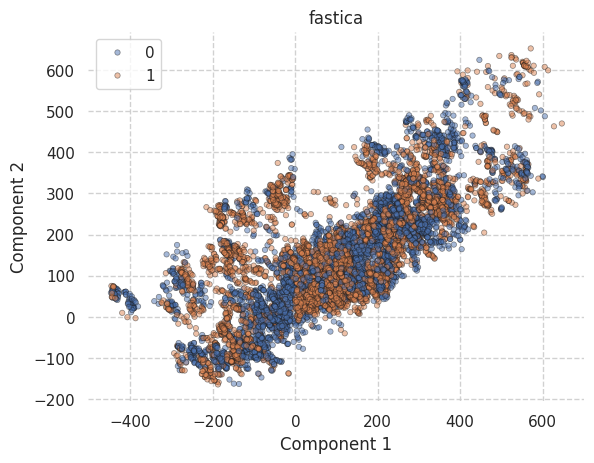

In [ ]:
# Standard ICA (no scaling)
df_tr1_ICA = dimRed(df_tr1,
                    split_id=[0.2,None],
                    model_id='fastica',
                    n_comp=5)

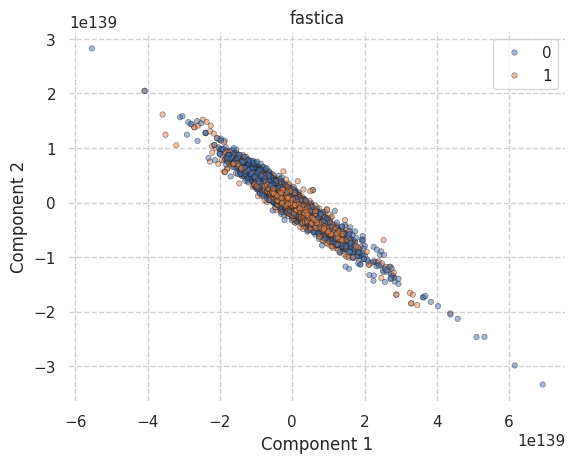

In [ ]:
# Standard ICA (no scaling)
df_tr2_ICA = dimRed(df_tr2,
                    split_id=[0.2,None],
                    model_id='fastica',
                    n_comp=5)

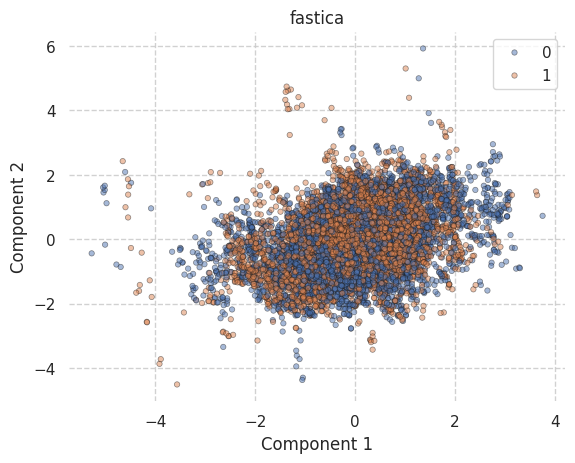

In [ ]:
'''StandardScaler ICA'''
df_tr1_ICA_sca0 = dimRed(df_tr1,
                         split_id=[0.2,None],
                         model_id='fastica',
                         n_comp=5,
                         scaler_id=[True,0])

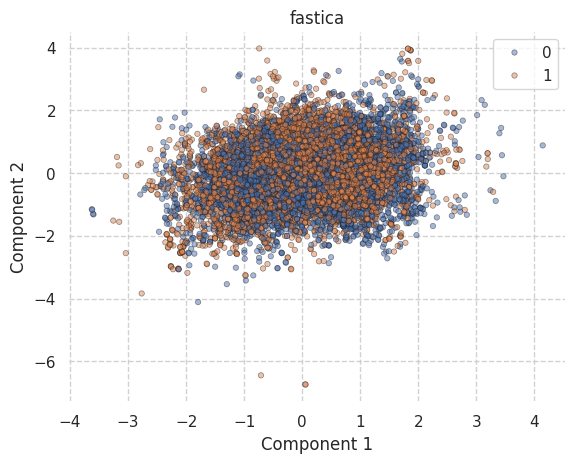

In [ ]:
'''StandardScaler ICA'''
df_tr2_ICA_sca0 = dimRed(df_tr2,
                         split_id=[0.2,None],
                         model_id='fastica',
                         n_comp=5,
                         scaler_id=[True,0])

Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90],
      dtype='object')
Target Variable: label

LDA
LDA : 0.523(0.055) -> 0.53s | 0.702 & 0.512 -> 0.11s | 0.667 -> 0.15s
KNN
KNN : 0.462(0.045) -> 0.92s | 0.982 & 0.537 -> 1.08s | 0.982 -> 1.6s
TREE
TREE : 0.468(0.015) -> 5.11s | 1.000 & 0.570 -> 1.35s | 1.000 -> 1.6s
NB
NB : 0.481(0.042) -> 0.06s | 0.592 & 0.557 -> 0.02s | 0.586 -> 0.017s
GBM
GBM : 0.452(0.053) -> 64.88s | 0.832 & 0.516 -> 15.69s | 0.813 -> 2.1e+01s
XGB
XGB : 0.485(0.051) -> 5.

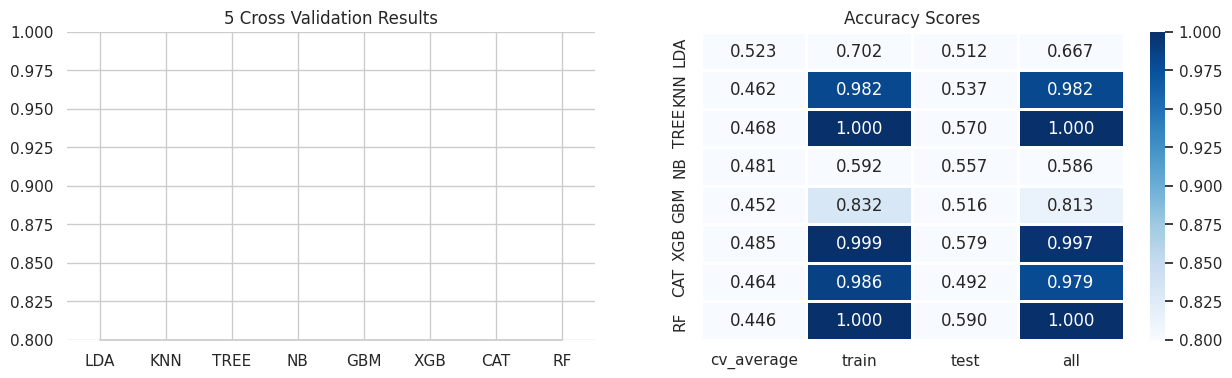

In [ ]:
modelEval(df_tr1_ICA_sca0,
          split_id=[0.2,None],
          plot_id=[False,True],
          cv_yrange=(0.8,1.0),
          hm_vvals=[0.8,1.0,0.9])

Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90],
      dtype='object')
Target Variable: label

LDA
LDA : 0.495(0.034) -> 0.61s | 0.712 & 0.433 -> 0.14s | 0.675 -> 0.15s
KNN
KNN : 0.479(0.024) -> 0.90s | 0.977 & 0.552 -> 1.13s | 0.978 -> 1.3s
TREE
TREE : 0.447(0.035) -> 5.18s | 1.000 & 0.644 -> 1.19s | 1.000 -> 1.7s
NB
NB : 0.483(0.047) -> 0.06s | 0.591 & 0.544 -> 0.02s | 0.586 -> 0.017s
GBM
GBM : 0.447(0.037) -> 62.71s | 0.849 & 0.459 -> 16.03s | 0.839 -> 2.1e+01s
XGB
XGB : 0.475(0.038) -> 4.

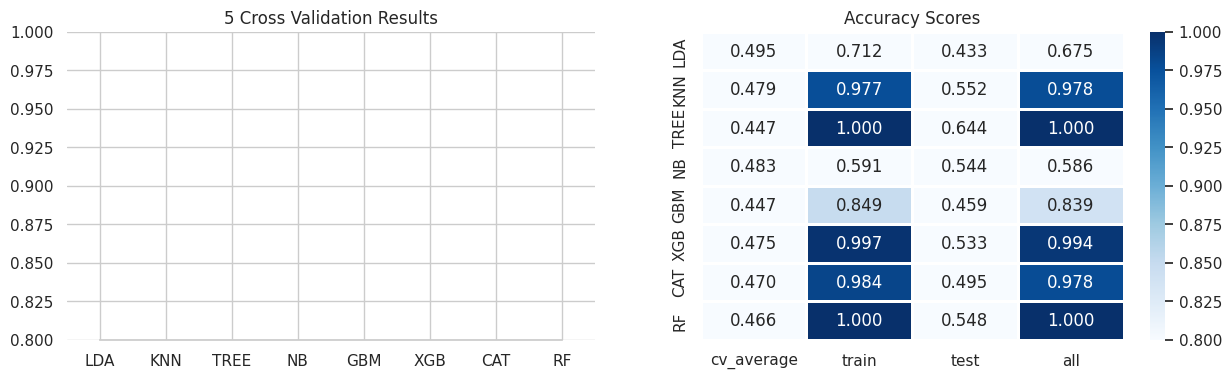

In [ ]:
modelEval(df_tr2_ICA_sca0,
          split_id=[0.2,None],
          plot_id=[False,True],
          cv_yrange=(0.8,1.0),
          hm_vvals=[0.8,1.0,0.9])

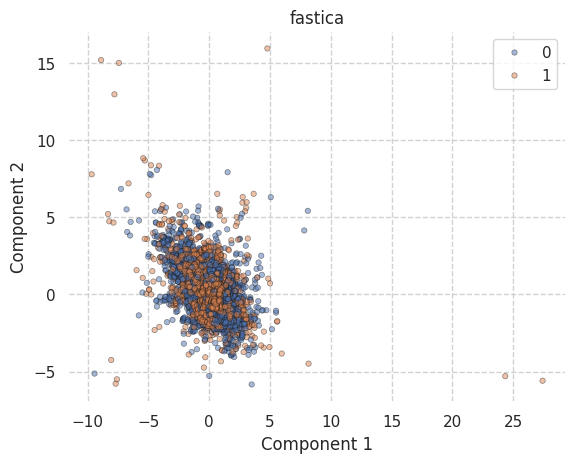

In [ ]:
'''RobustScaler ICA'''
df_tr1_ICA_sca1 = dimRed(df_tr1,
                         split_id=[0.2,None],
                         model_id='fastica',
                         n_comp=5,
                         scaler_id=[True,1])

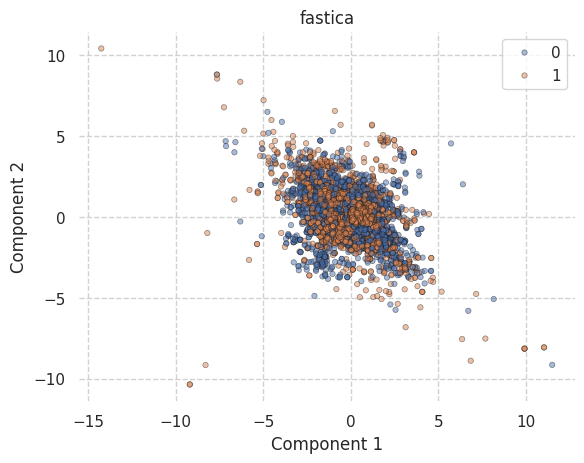

In [ ]:
'''RobustScaler ICA'''
df_tr2_ICA_sca1 = dimRed(df_tr2,
                         split_id=[0.2,None],
                         model_id='fastica',
                         n_comp=5,
                         scaler_id=[True,1])

Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90],
      dtype='object')
Target Variable: label

LDA
LDA : 0.523(0.055) -> 0.54s | 0.702 & 0.512 -> 0.17s | 0.667 -> 0.16s
KNN
KNN : 0.466(0.049) -> 1.32s | 0.976 & 0.547 -> 1.18s | 0.976 -> 1.3s
TREE
TREE : 0.508(0.032) -> 4.73s | 1.000 & 0.477 -> 1.26s | 1.000 -> 1.8s
NB
NB : 0.459(0.040) -> 0.11s | 0.560 & 0.493 -> 0.03s | 0.604 -> 0.026s
GBM
GBM : 0.502(0.049) -> 62.19s | 0.854 & 0.509 -> 15.59s | 0.825 -> 2.1e+01s
XGB
XGB : 0.507(0.054) -> 5.

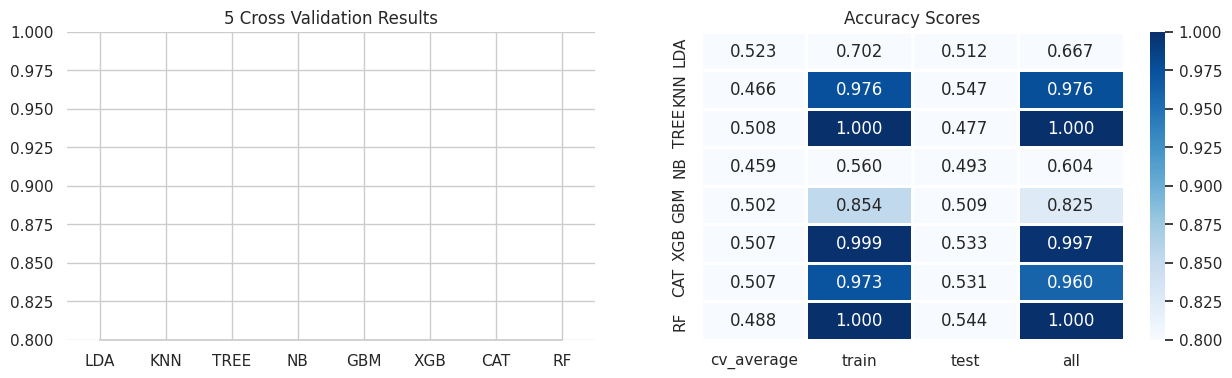

In [ ]:
modelEval(df_tr1_ICA_sca1,
          split_id=[0.2,None],
          plot_id=[False,True],
          cv_yrange=(0.8,1.0),
          hm_vvals=[0.8,1.0,0.9])

Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90],
      dtype='object')
Target Variable: label

LDA
LDA : 0.495(0.034) -> 0.51s | 0.712 & 0.433 -> 0.16s | 0.675 -> 0.16s
KNN
KNN : 0.471(0.035) -> 0.91s | 0.971 & 0.574 -> 1.13s | 0.970 -> 1.3s
TREE
TREE : 0.454(0.025) -> 5.03s | 1.000 & 0.504 -> 1.34s | 1.000 -> 1.6s
NB
NB : 0.448(0.058) -> 0.07s | 0.529 & 0.451 -> 0.02s | 0.534 -> 0.018s
GBM
GBM : 0.466(0.043) -> 60.87s | 0.837 & 0.530 -> 15.91s | 0.816 -> 2e+01s
XGB
XGB : 0.471(0.033) -> 5.96

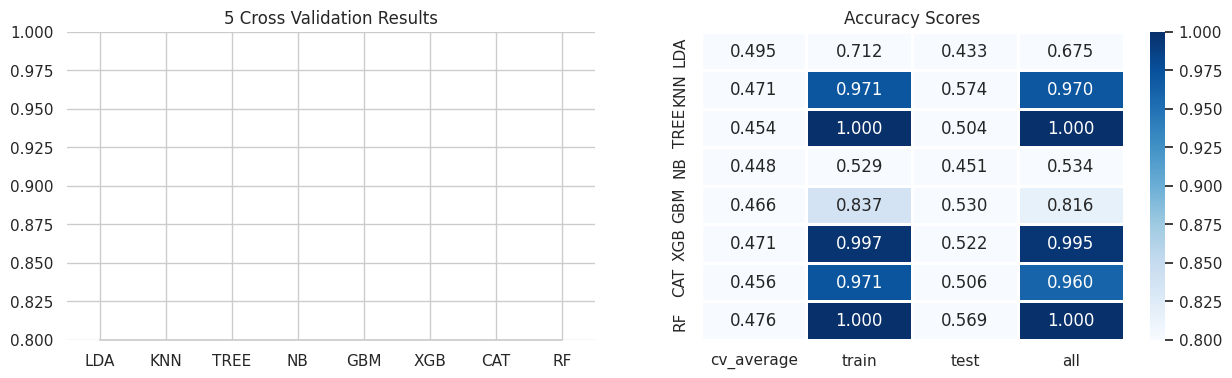

In [ ]:
modelEval(df_tr2_ICA_sca1,
          split_id=[0.2,None],
          plot_id=[False,True],
          cv_yrange=(0.8,1.0),
          hm_vvals=[0.8,1.0,0.9])

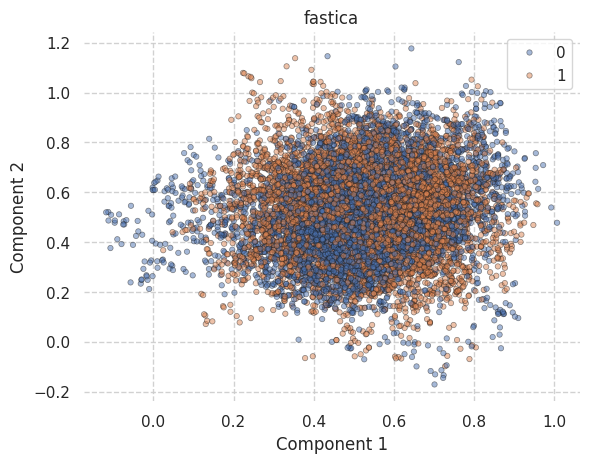

In [ ]:
'''MinMaxScaler ICA'''
df_tr1_ICA_sca2 = dimRed(df_tr1,
                         split_id=[0.2,None],
                         model_id='fastica',
                         n_comp=5,
                         scaler_id=[True,2])


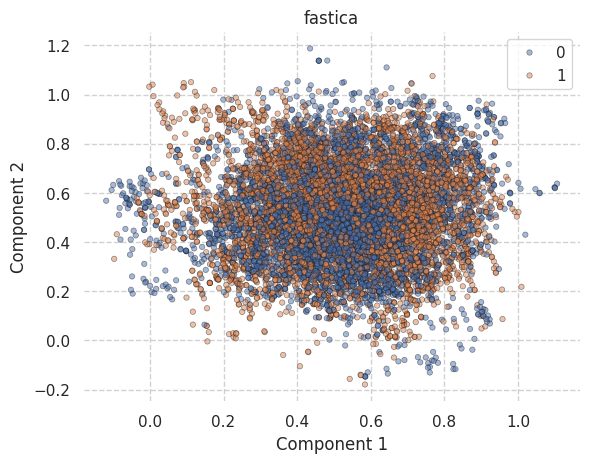

In [ ]:
'''MinMaxScaler ICA'''
df_tr2_ICA_sca2 = dimRed(df_tr2,
                         split_id=[0.2,None],
                         model_id='fastica',
                         n_comp=5,
                         scaler_id=[True,2])


Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90],
      dtype='object')
Target Variable: label

LDA
LDA : 0.523(0.055) -> 1.13s | 0.702 & 0.512 -> 0.16s | 0.667 -> 0.14s
KNN
KNN : 0.465(0.046) -> 0.87s | 0.978 & 0.519 -> 1.10s | 0.978 -> 1.3s
TREE
TREE : 0.510(0.027) -> 5.25s | 1.000 & 0.518 -> 1.26s | 1.000 -> 2.0s
NB
NB : 0.509(0.035) -> 0.06s | 0.601 & 0.508 -> 0.02s | 0.603 -> 0.018s
GBM
GBM : 0.504(0.037) -> 62.28s | 0.824 & 0.481 -> 16.22s | 0.813 -> 2.1e+01s
XGB
XGB : 0.472(0.017) -> 5.

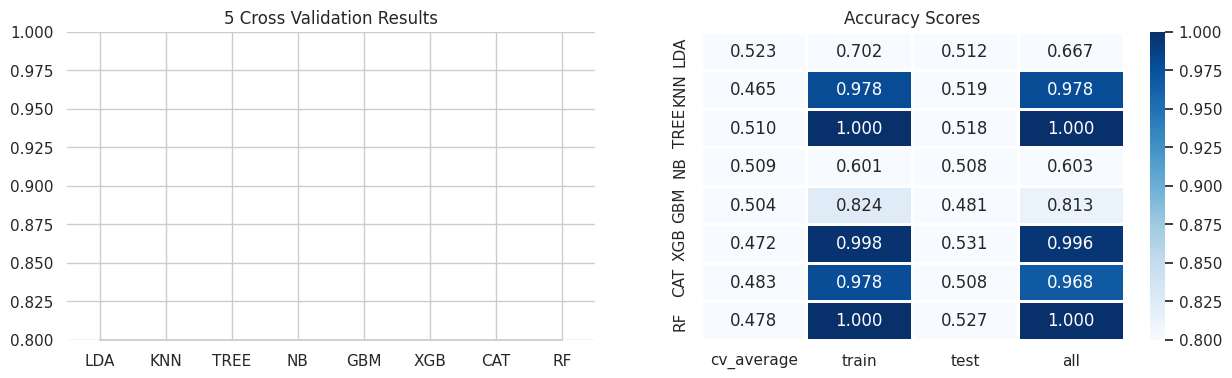

In [ ]:
modelEval(df_tr1_ICA_sca2,
          split_id=[0.2,None],
          plot_id=[False,True],
          cv_yrange=(0.8,1.0),
          hm_vvals=[0.8,1.0,0.9])

Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90],
      dtype='object')
Target Variable: label

LDA
LDA : 0.495(0.034) -> 0.53s | 0.712 & 0.433 -> 0.14s | 0.675 -> 0.14s
KNN
KNN : 0.476(0.032) -> 0.87s | 0.976 & 0.518 -> 1.09s | 0.976 -> 1.3s
TREE
TREE : 0.485(0.053) -> 5.82s | 1.000 & 0.527 -> 1.30s | 1.000 -> 1.8s
NB
NB : 0.504(0.027) -> 0.06s | 0.595 & 0.490 -> 0.02s | 0.595 -> 0.017s
GBM
GBM : 0.471(0.051) -> 61.93s | 0.816 & 0.491 -> 15.90s | 0.803 -> 2e+01s
XGB
XGB : 0.478(0.045) -> 4.32

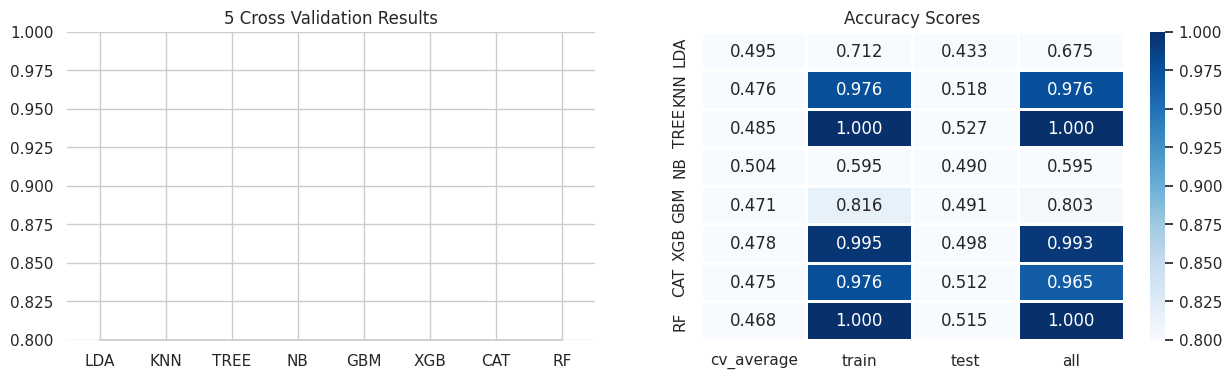

In [ ]:
modelEval(df_tr2_ICA_sca2,
          split_id=[0.2,None],
          plot_id=[False,True],
          cv_yrange=(0.8,1.0),
          hm_vvals=[0.8,1.0,0.9])

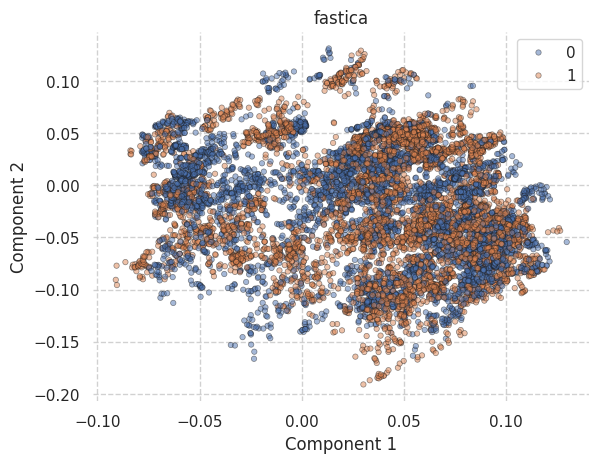

In [ ]:
'''Normaliser ICA'''
df_tr1_ICA_sca3 = dimRed(df_tr1,
                         split_id=[0.2,None],
                         model_id='fastica',
                         n_comp=5,
                         scaler_id=[True,3])

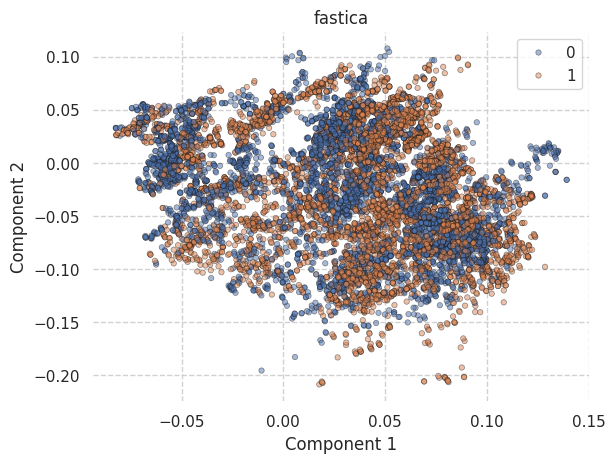

In [ ]:
'''Normaliser ICA'''
df_tr2_ICA_sca3 = dimRed(df_tr2,
                         split_id=[0.2,None],
                         model_id='fastica',
                         n_comp=5,
                         scaler_id=[True,3])

Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90],
      dtype='object')
Target Variable: label

LDA
LDA : 0.501(0.061) -> 0.59s | 0.717 & 0.449 -> 0.14s | 0.693 -> 0.16s
KNN
KNN : 0.430(0.047) -> 0.89s | 0.984 & 0.532 -> 1.12s | 0.984 -> 1.7s
TREE
TREE : 0.492(0.027) -> 5.47s | 1.000 & 0.605 -> 1.51s | 1.000 -> 2.1s
NB
NB : 0.489(0.061) -> 0.07s | 0.604 & 0.442 -> 0.02s | 0.591 -> 0.014s
GBM
GBM : 0.440(0.045) -> 62.14s | 0.893 & 0.537 -> 15.54s | 0.875 -> 2e+01s
XGB
XGB : 0.478(0.037) -> 3.46

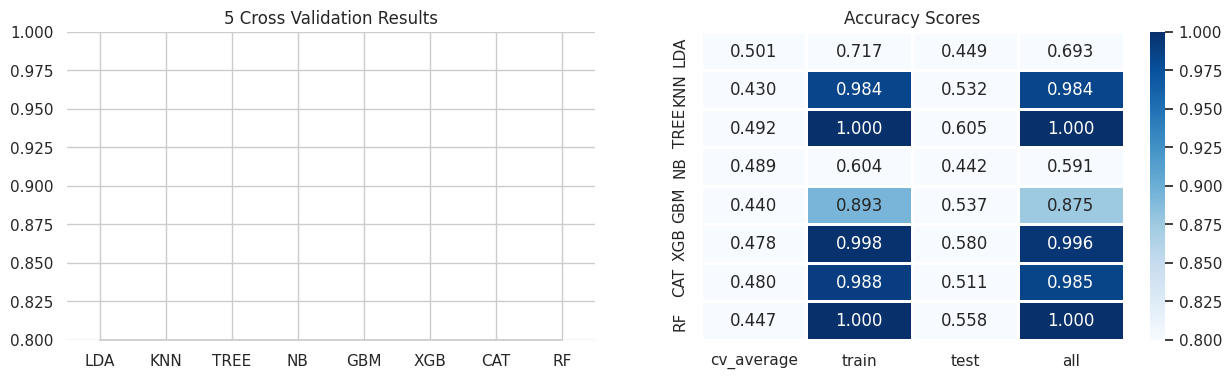

In [ ]:
modelEval(df_tr1_ICA_sca3,
          split_id=[0.2,None],
          plot_id=[False,True],
          cv_yrange=(0.8,1.0),
          hm_vvals=[0.8,1.0,0.9])


Evaluation Function
Cross Validation Activated, n_splits : 5, scoring metric: accuracy
Train/Evaluation Set Spit Activated: 0.2

Using Features: Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90],
      dtype='object')
Target Variable: label

LDA
LDA : 0.489(0.024) -> 0.48s | 0.721 & 0.411 -> 0.11s | 0.691 -> 0.14s
KNN
KNN : 0.466(0.049) -> 0.85s | 0.980 & 0.584 -> 1.12s | 0.980 -> 1.3s
TREE
TREE : 0.503(0.052) -> 6.08s | 1.000 & 0.486 -> 1.32s | 1.000 -> 1.8s
NB
NB : 0.482(0.075) -> 0.06s | 0.608 & 0.442 -> 0.02s | 0.604 -> 0.019s
GBM
GBM : 0.467(0.048) -> 59.90s | 0.895 & 0.471 -> 15.48s | 0.881 -> 2e+01s
XGB
XGB : 0.490(0.078) -> 3.71

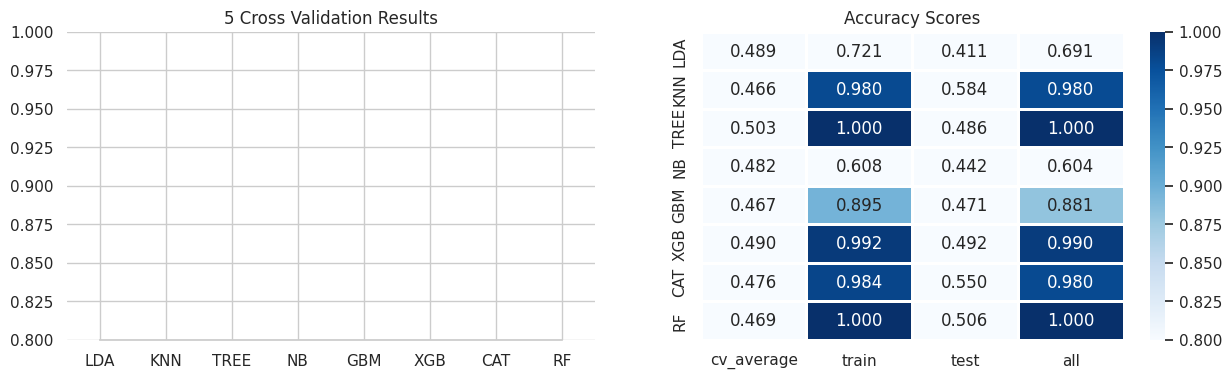

In [ ]:
modelEval(df_tr2_ICA_sca3,
          split_id=[0.2,None],
          plot_id=[False,True],
          cv_yrange=(0.8,1.0),
          hm_vvals=[0.8,1.0,0.9])
